# Title: Pt film grain border detection

author: Nikolay Chehlarov

email: chehlarow@yahoo.com

git: https://github.com/Chehlarov

date: 17.02.2022.

# Abstract
This work describes the development of an algorithm for image segmentation. The goal is to detect Pt grain borders from SEM images. Four U-nets are implemented and evaluated. The best U-net type for the task proved to be Spatial Attention U-Net. Hyper parameter tuning is performed to find optimal settings for the model.

# Problem definition
## Background
Pt films are used in engineering for various purposes. For example for temperature or strain sensing. The distribution of grain sizes is an important property for the product function. Traditional based approaches failed to achieve acceptable results. ML algorithm was developed with good performance (https://github.com/Chehlarov/Machine-Learning/tree/main/00%20-%20project). In production environment photos with different noise level and scale have to be analyzed. The ML approach did not deliver the expected generalization and production readiness. Deep learning approach is expected to meet the production needs.
## Goal
Create a model to perform image segmentation of Pt grains from a SEM image. Pixels should be classified as border or not border.

# Architecture selection
The task is <a href="https://paperswithcode.com/area/computer-vision/semantic-segmentation">semantic segmentation</a>, several suitable architecture exist. The difference between grain border segmentation and typical segmentation task is that grain borders are continues curves with small width. Similar standard task is <a href='https://paperswithcode.com/task/retinal-vessel-segmentation'>Retinal Vessel Segmentation </a>. Looking into the top performing models, one could easily notice that several models are based on U-net architecture. U-net is also the most implemented paper. U-net types can summarized to:
- U-net (classical)
- R2U-Net (Recurrent Residual)
- SA-UNet (Spatial Attention U-Net; top performer among U-nets)
- DUNet (deformable network)
- BCDU-Net (Bi-Directional ConvLSTM U-Net)
- Residual U-Net
- Att U-Net (Attention U-Net)
- Attention Residual U-Net 
- Channel Attention Residual U-Net (CAR U-net)

U-net is supposed to perform well even on small dataset.The available labeled dataset for border segmentation is small and U-net might be suitable solution. A couple of the U-net versions will be implemented and compared:
- Spatial Attention U-Net
- U-net
- Attention U-net
- Attention Residual U-net

## Spatial Attention U-Net
Highlights:
- works well with small datasets
- uses attention module which infers the attention map along the spatial dimension
- employs structured dropout convolutional blocks instead of the original convolutional blocks (prevents overfitting)
- top results achieved on retinal blood vessels dataset

SA U-net architecture
<img src="figures/SA_U-net.png" alt="Drawing" style="width: 600px;"/>
attention module
<img src="figures/SA module.png" alt="Drawing" style="width: 600px;"/>

## U-Net
Highlights:
- very popular, proven model for image segmentation
- the base model used for the four implemented models in this work
- originally developed for biomedical image segmentation
- The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization

U-net architecture
<img src="figures/U-net.png" alt="Drawing" style="width: 600px;"/>

## Attention U-Net
Highlights:
- based on U-net
- adds attention gates to the skip connections
- learn to suppress irrelevant regions
- minimal computational overhead

Attention U-net architecture
<img src="figures/Attention_U-net.png" alt="Drawing" style="width: 600px;"/>

Attention gate
<img src="figures/Attention_U-net_AG.png" alt="Drawing" style="width: 600px;"/>

## Attention Residual U-net
Highlights:
- based on U-net
- combines residual U-net skip connections and attention U-net gates
- overcomes problems with vanishing gradients

residual block
<img src="figures/residual_block.png" alt="Drawing" style="width: 200px;"/>

# Implementation

The implementation is based on several Github repositories. There are modifications to adapt to the current task. The code is based on tensorflow 2.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt

import tensorflow_addons as tfa

from focal_loss import BinaryFocalLoss

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from skimage import io, color, measure
from skimage.util import img_as_float32, img_as_ubyte
from skimage import filters
from skimage.feature import peak_local_max
from skimage.morphology import binary_dilation, flood_fill #skeletonize, disk, binary_closing, 
from skimage.segmentation import clear_border, watershed

from scipy import ndimage

import pandas as pd

import cv2

import time

import os

# import seaborn as sns

## Function for models building and evaluation
This section contains the main building blocks for the U-net models.

In [2]:
# A few metrics and losses

def dice_coef(y_true, y_pred):
    """
    Basically F1 score; harmonic mean between precition and recall
    https://www.youtube.com/watch?v=AZr64OxshLo&t=15s
    better for optimization (loss function) because it tries to balance precition and recall
    """
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    """
    bassically IoU
    https://www.youtube.com/watch?v=AZr64OxshLo&t=15s
    better as metric because it is easy to interprit
    """
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# not used
# def jacard_coef_loss(y_true, y_pred):
#     return 1 - jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def mae_euclidean(y_true, y_pred):
    """
    Mean square error of euclean distance between the predicted distance map and the true distance map
    This metric is not very stable, one false positive pixel inside a grain can change the metric significantly.
    The metric has bias towards the grain size distribution - fine grain structures will have lower 
    euclidean distances and hence smaller MSE values.
    this function is not differentiable and cannot be used as loss function.
    """
    y_true_inv = (y_true == 0)
    y_true_inv = tf.cast(y_true_inv, tf.uint8)
    y_true_distance_map = tfa.image.euclidean_dist_transform(y_true_inv)  
    
    y_pred_inv = (y_pred < 0.5)
    y_pred_inv = tf.cast(y_pred_inv, tf.uint8)
    y_pred_distance_map = tfa.image.euclidean_dist_transform(y_pred_inv)
    
    # res = tf.math.squared_difference(y_pred_distance_map, y_true_distance_map) # squared error leads to high penaulty for misclasification
    res = tf.math.abs(tf.math.subtract(y_pred_distance_map, y_true_distance_map))
    res = tf.keras.backend.mean(res)
    
    return res

In [3]:
#unit test
y_true = np.array([0,  0, 1, 0, 1, 0, 1])
y_pred = np.array([1., 1, 0, 0, 1, 0, 1])
y_true = tf.expand_dims(y_true, -1)
y_pred = tf.expand_dims(y_pred, -1)
assert(np.abs(mae_euclidean(y_true, y_pred).numpy() - 0.5714286) < 0.0001)

In [4]:
# main blocks of the U-nets

class DropBlock2D(layers.Layer):
    """
    See: https://arxiv.org/pdf/1810.12890.pdf
    Used in SA-UNet
    """
    
    def _normalize_data_format(self, value):
        # https://stackoverflow.com/questions/53442190/importerror-cannot-import-name-normalize-data-format
        if value is None:
            value = K.image_data_format()
        data_format = value.lower()
        if data_format not in {'channels_first', 'channels_last'}:
            raise ValueError('The `data_format` argument must be one of '
                             '"channels_first", "channels_last". Received: ' +
                             str(value))
        return data_format
    
    def __init__(self,
                 block_size,
                 keep_prob,
                 sync_channels=False,
                 data_format=None,
                 **kwargs):
        """Initialize the layer.
        :param block_size: Size for each mask block.
        :param keep_prob: Probability of keeping the original feature.
        :param sync_channels: Whether to use the same dropout for all channels.
        :param data_format: 'channels_first' or 'channels_last' (default).
        :param kwargs: Arguments for parent class.
        """
        super(DropBlock2D, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channels = sync_channels
        self.data_format = self._normalize_data_format(data_format) 
        self.input_spec = tf.keras.layers.InputSpec(ndim=4)
        self.supports_masking = True
        


    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob,
                  'sync_channels': self.sync_channels,
                  'data_format': self.data_format}
        base_config = super(DropBlock2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def _get_gamma(self, height, width):
        """Get the number of activation units to drop"""
        height, width = K.cast(height, K.floatx()), K.cast(width, K.floatx())
        block_size = K.constant(self.block_size, dtype=K.floatx())
        return ((1.0 - self.keep_prob) / (block_size ** 2)) *\
               (height * width / ((height - block_size + 1.0) * (width - block_size + 1.0)))

    def _compute_valid_seed_region(self, height, width):        
        positions = K.concatenate([
            tf.expand_dims(K.tile(K.expand_dims(tf.range(height), axis=1), [1, width]), axis=-1),
            tf.expand_dims(K.tile(K.expand_dims(tf.range(width), axis=0), [height, 1]), axis=-1),
        ], axis=-1)
        half_block_size = self.block_size // 2
        valid_seed_region = K.switch(
            K.all(
                K.stack(
                    [
                        positions[:, :, 0] >= half_block_size,
                        positions[:, :, 1] >= half_block_size,
                        positions[:, :, 0] < height - half_block_size,
                        positions[:, :, 1] < width - half_block_size,
                    ],
                    axis=-1,
                ),
                axis=-1,
            ),
            tf.ones((height, width)),
            tf.zeros((height, width)),
        )
        return tf.expand_dims(tf.expand_dims(valid_seed_region, axis=0), axis=-1)

    def _compute_drop_mask(self, shape):
        height, width = shape[1], shape[2]
        mask = tf.keras.backend.random_bernoulli(shape, p=self._get_gamma(height, width))
        mask *= self._compute_valid_seed_region(height, width)
        mask = tf.keras.layers.MaxPool2D(
            pool_size=(self.block_size, self.block_size),
            padding='same',
            strides=1,
            data_format='channels_last',
        )(mask)
        return 1.0 - mask

    def call(self, inputs, training=None):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 3, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], shape[2], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 3, 1, 2])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs, training=training)
    

def spatial_attention(input_feature):
    """
    Used in the bottleneck of SA-UNet
    """
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        # channel = input_feature._keras_shape[-1]
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1 # assert avg_pool._keras_shape[-1] == 1
    max_pool = layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1 # assert max_pool._keras_shape[-1] == 1
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    assert max_pool.shape[-1] == 1 # assert concat._keras_shape[-1] == 2
    cbam_feature = layers.Conv2D(filters=1,
                                  kernel_size=kernel_size,
                                  strides=1,
                                  padding='same',
                                  activation='sigmoid',
                                  kernel_initializer='he_normal',
                                  use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1 # assert cbam_feature._keras_shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = layers.Permute((3, 1, 2))(cbam_feature)

    return layers.multiply([input_feature, cbam_feature])


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    """
    Convolution block of 2 Conv2D
    """
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    """
    lambda function to repeat Repeats the elements of a tensor along an axis
    by a factor of rep.
    If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    (None, 256,256,6), if specified axis=3 and rep=2.
    """
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

    
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    """
    Residual convolutional block.                                   
    conv - BN - Activation - conv - BN  - dropout - shortcut+BN - shortcut+BN - Activation                                     
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    """

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path


def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):
    """
    Attention gate; 
    see https://arxiv.org/pdf/1804.03999.pdf fig 2
    """
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [5]:
# models
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    """
    UNet
    """
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    #print(model.summary())
    return model


def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    """
    Attention UNet
    """
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model


def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    """
    Attention Residual UNet
    """
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


def SA_UNet(input_shape, block_size=7, keep_prob=0.9, start_neurons=16):
    """
    Spatial Attention U-Net
    """
    inputs = layers.Input(input_shape)
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1= layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)


    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)


    convm = layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = layers.BatchNormalization()(convm)
    convm = layers.Activation('relu')(convm)
    convm = spatial_attention(convm)
    convm = layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = layers.BatchNormalization()(convm)
    convm = layers.Activation('relu')(convm)


    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = layers.concatenate([deconv3, conv3])

    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = layers.BatchNormalization()(uconv3)
    uconv3 = layers.Activation('relu')(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = layers.BatchNormalization()(uconv3)
    uconv3 = layers.Activation('relu')(uconv3)

    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])

    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = layers.BatchNormalization()(uconv2)
    uconv2 = layers.Activation('relu')(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = layers.BatchNormalization()(uconv2)
    uconv2 = layers.Activation('relu')(uconv2)

    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])


    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = layers.BatchNormalization()(uconv1)
    uconv1 = layers.Activation('relu')(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = layers.BatchNormalization()(uconv1)
    uconv1 = layers.Activation('relu')(uconv1)
    output_layer_noActi = layers.Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = layers.Activation('sigmoid')(output_layer_noActi)

    model = models.Model(inputs=inputs, outputs=output_layer, name="SA_UNet")
    
    #     model.compile(optimizer=Adam(learning_rate=1e-3),
    #                   loss='binary_crossentropy',
    #                   metrics=['accuracy',[dice_coef, mse_euclidean])

    return model

In [6]:
# fuctions for model analysis
def plot_history(history, title=""):
    """
    Plots a trainning hsitory
    """
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(title, fontsize=16)
    
    plt.subplot(1, 3, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.5)
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)    
    plt.plot(epochs, history.history['mae_euclidean'], 'y', label='mae_euclidean')
    plt.plot(epochs, history.history['val_mae_euclidean'], 'r', label='val_mae_euclidean')
    plt.title('MAE euclidean distances from borders')
    plt.xlabel('Epochs')
    plt.ylabel('MAE euclidean')
    plt.ylim(0, 10)
    plt.legend()
    plt.grid()
        
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history.history['jacard_coef'], 'y', label='jacard_coef')
    plt.plot(epochs, history.history['val_jacard_coef'], 'r', label='val_jacard_coef')
    plt.title('Training and validation jacard coef')
    plt.xlabel('Epochs')
    plt.ylabel('jacard coef')
    plt.ylim(0, 0.8)
    plt.legend()
    plt.grid()
        
    plt.show()
    
    
def visual_eval(model, test_img, mask_expected=None, thresh = 0.5, show=True):
    """
    Provides visual evaluation for the performance of a model.
    """
    test_img = img_as_float32(test_img).copy()
    original_img = test_img[:, :, 0].copy()

    X = np.expand_dims(test_img, axis=0)
    #     X = np.expand_dims(X, axis=-1)
    mask_predicted = model.predict(X)[0, :, :, 0]
    mask_predicted = mask_predicted > thresh # thresholding
    mask_expected = mask_expected[:, :, 0]
    
    img_review = color.gray2rgb(original_img)
    if mask_expected is not None:
        mask_expected = mask_expected.astype(bool)
        img_review[mask_expected & mask_predicted] = (0, 1, 0) # tp, green
        img_review[mask_expected & ~mask_predicted] = (0, 0, 1) # fn, low recall score
        img_review[~mask_expected & mask_predicted] = (1, 1, 0) # fp, low precision score
    else:
        img_review[mask_predicted] = (0, 1, 0) # predicted, 
    
    # adding legend
    cv2.putText(img_review, "TP", (5, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 1, 0), 1)
    cv2.putText(img_review, "FP", (18, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (1, 1, 0), 1)
    cv2.putText(img_review, "FN", (31, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 1), 1)
    
    if show:
        plt.figure(figsize=(12,12))
        plt.imshow(img_review)
        plt.title("Mark-up picture")
        plt.show()

    return img_review #, mask_expected, mask_predicted


def plot_train_val(model, idx_train=None, idx_val=None):
    # plot prediction accuracy on train and validation dataset
    if idx_train == None:
        idx_train = np.random.randint(0, X_train.shape[0])
    if idx_val == None:
        idx_val = np.random.randint(0, X_val.shape[0])
    
    plt.figure(figsize=(18,10))

    plt.subplot(1, 2, 1)
    im = visual_eval(model=model, test_img=X_train[idx_train], mask_expected=y_train[idx_train], show=False)
    plt.imshow(im)
    plt.title(f"Train image {idx_train}")

    plt.subplot(1, 2, 2)
    im = visual_eval(model=model, test_img=X_val[idx_val], mask_expected=y_val[idx_val], show=False)
    plt.imshow(im)
    plt.title(f"Validation image {idx_val}")

    plt.show()

## Train and test data loading

Train and test datasets are organized in separate folders. The dataset is prepared from one image with scale 500x and a second image 1000x. The images are sliced into patches with 256x176. Augmentation is applied to all patches by applying median filter. The patches are divided so that patch and its augmentation are either in train, validation or test; this is done to avoid information leak. Augmentation could be automated with data generator, but it is possible some augmentation settings to produce unrealistic images. It is strongly recommended to check the visual perception of the augmentation if such approach is considered.

In [7]:
def create_augmneted_img(path):
    """
    Function to create augmented images by appling median filter
    """
    for f_name in os.listdir(path):
        if f_name.split("_")[-1] == 'image.tif' and f_name.startswith("patch1000_"):
            print(f"Working on {f_name}")
            img = io.imread(train_test_path + r"\\" + f_name)
            img = img_as_float32(img)
            aug = filters.median(img)
            new_name = str(train_test_path + r"\\" + f_name).replace("patch1000_", "patch1000_aug")
            io.imsave(new_name, img_as_ubyte(aug))

            mask_name = f_name.replace("image", "mask")
            mask = io.imread(train_test_path + r"\\" + mask_name)
            new_name = new_name.replace("_image", "_mask")
            io.imsave(new_name, img_as_ubyte(mask))
            
#create_augmneted_img(r"datasets/train") # already done

In [8]:
def load_data(path):
    """
    loads images and masks from a folder
    all images and mask should be 256x176 (w x h)
    """
    imgs = []
    masks = []
    for f_name in os.listdir(path):
        if f_name.split("_")[-1] == 'image.tif':
            # print(f"Working on {f_name}")
            img = io.imread(path + r"\\" + f_name)
            assert img.shape == (176, 256)
            img = img_as_float32(img)
            imgs.append(img)

            mask_name = f_name.replace("image", "mask")
            mask = io.imread(path + r"\\" + mask_name)
            mask = mask // 255
            masks.append(mask)
    imgs = np.expand_dims(np.array(imgs), -1)
    masks = np.expand_dims(np.array(masks), -1)
    return imgs, masks

In [9]:
X_train, y_train = load_data("datasets/train")
X_val, y_val = load_data("datasets/validation")
X_test, y_test = load_data("datasets/test")

X_train = tf.cast(X_train, tf.float16)
X_val = tf.cast(X_val, tf.float16)
X_test = tf.cast(X_test, tf.float16)

In [10]:
X_train.shape, X_val.shape,  X_test.shape

(TensorShape([32, 176, 256, 1]),
 TensorShape([8, 176, 256, 1]),
 TensorShape([4, 176, 256, 1]))

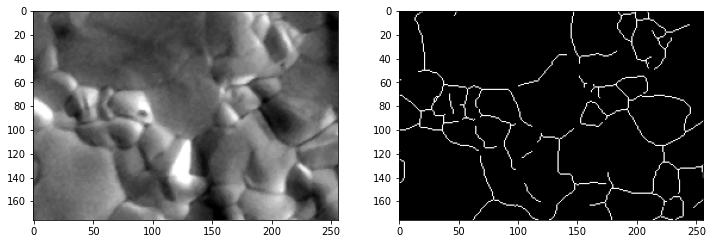

In [11]:
# sanity check for mating of mages and masks; run a couple of times
# t = np.random.randint(X_train.shape[0])
t = np.random.randint(X_train.shape[0])
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.imshow(tf.cast(X_train[t], float), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y_train[t], cmap='gray')
plt.show()

In [12]:
total_border_pixels = np.sum(y_train)
total_pixels = y_train.shape[0] * y_train.shape[1] * y_train.shape[2] * y_train.shape[3]
border_pix_ratio = total_border_pixels / total_pixels
print(f"Grain border pixels / all pixels = {border_pix_ratio}")

Grain border pixels / all pixels = 0.07478609952059659


In [13]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
input_shape

(176, 256, 1)

## Model selection

Several iterations and hyperparameter searches have been done in the background. The next sections will start with setting known to produce good results. <br>
Objectives:
- maximize Jacard coefficient; Jacard coefficient is presenting IoU
- minimize the MAE euclidean distances; Euclidean distances are calculated for the ground truth and the predicted border mask. The differences between the distances is measured by MAE. It is preferred to have low and stable MAE euclidean distances. MAE euclidean distance error is not stable by nature, because even one FP pixel in the middle of a grain could increase the metric significantly. MAE euclidean distances are used in the postprocessing step by watershed algorithm, making the metric important.
- prevent overfitting

## SA UNet model trials

As a starting point, the following parameters have been found to be optimal:block_size=19, keep_prob=0.8, start_neurons=20

In [14]:
# SA Unet1
tf.random.set_seed(14)
model_sa_unet1 = SA_UNet(input_shape, block_size=19, keep_prob=0.8, start_neurons=20)
model_sa_unet1.compile(optimizer=Adam(learning_rate=1e-2),
                         loss = dice_coef_loss,
                         metrics=[mae_euclidean, jacard_coef]
                         )
start = time.time()
history_sa_unet1 = model_sa_unet1.fit(X_train, y_train,
                                    validation_data = (X_val, y_val),
                                    batch_size = 8, # no resources for 16
                                    epochs=200
                                   )
print(f"Model trained for {time.time() - start}s")
model_sa_unet1.save("2022-02-17 SA-UNet1 200epochs.hdf5")

Epoch 1/200
4/4 [==============================] - 10s 479ms/step - loss: 0.8405 - mae_euclidean: 5.2724 - jacard_coef: 0.0874 - val_loss: 0.8714 - val_mae_euclidean: 5.8165 - val_jacard_coef: 0.0687
Epoch 2/200
4/4 [==============================] - 1s 374ms/step - loss: 0.7713 - mae_euclidean: 3.6544 - jacard_coef: 0.1293 - val_loss: 0.8798 - val_mae_euclidean: 5.6584 - val_jacard_coef: 0.0640
Epoch 3/200
4/4 [==============================] - 1s 376ms/step - loss: 0.7341 - mae_euclidean: 3.3476 - jacard_coef: 0.1534 - val_loss: 0.9941 - val_mae_euclidean: 121.6934 - val_jacard_coef: 0.0030
Epoch 4/200
4/4 [==============================] - 1s 373ms/step - loss: 0.6905 - mae_euclidean: 2.9527 - jacard_coef: 0.1831 - val_loss: 1.0000 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 3.6859e-05
Epoch 5/200
4/4 [==============================] - 1s 374ms/step - loss: 0.6529 - mae_euclidean: 2.8639 - jacard_coef: 0.2107 - val_loss: 1.0000 - val_mae_euclidean: 184467429741

4/4 [==============================] - 1s 375ms/step - loss: 0.3298 - mae_euclidean: 1.0918 - jacard_coef: 0.5042 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 6.3458e-05
Epoch 39/200
4/4 [==============================] - 1s 375ms/step - loss: 0.3234 - mae_euclidean: 1.1033 - jacard_coef: 0.5114 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 7.5992e-05
Epoch 40/200
4/4 [==============================] - 1s 376ms/step - loss: 0.3261 - mae_euclidean: 1.2548 - jacard_coef: 0.5083 - val_loss: 0.9998 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 1.0925e-04
Epoch 41/200
4/4 [==============================] - 1s 373ms/step - loss: 0.3270 - mae_euclidean: 1.1142 - jacard_coef: 0.5075 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 8.9689e-05
Epoch 42/200
4/4 [==============================] - 1s 375ms/step - loss: 0.3267 - mae_euclidean: 1.2009 - jacard_coef: 0

Epoch 75/200
4/4 [==============================] - 2s 397ms/step - loss: 0.2924 - mae_euclidean: 1.0098 - jacard_coef: 0.5476 - val_loss: 0.9874 - val_mae_euclidean: 32.9031 - val_jacard_coef: 0.0064
Epoch 76/200
4/4 [==============================] - 2s 396ms/step - loss: 0.2940 - mae_euclidean: 1.0228 - jacard_coef: 0.5458 - val_loss: 0.9951 - val_mae_euclidean: 56.3397 - val_jacard_coef: 0.0025
Epoch 77/200
4/4 [==============================] - 2s 397ms/step - loss: 0.3053 - mae_euclidean: 1.3810 - jacard_coef: 0.5331 - val_loss: 0.9901 - val_mae_euclidean: 47.0294 - val_jacard_coef: 0.0050
Epoch 78/200
4/4 [==============================] - 2s 396ms/step - loss: 0.3022 - mae_euclidean: 1.2327 - jacard_coef: 0.5359 - val_loss: 0.9946 - val_mae_euclidean: 56.1145 - val_jacard_coef: 0.0027
Epoch 79/200
4/4 [==============================] - 2s 398ms/step - loss: 0.2932 - mae_euclidean: 0.9684 - jacard_coef: 0.5468 - val_loss: 0.9956 - val_mae_euclidean: 77.2754 - val_jacard_coef: 0.

Epoch 116/200
4/4 [==============================] - 2s 400ms/step - loss: 0.2640 - mae_euclidean: 0.8208 - jacard_coef: 0.5826 - val_loss: 0.4533 - val_mae_euclidean: 2.8338 - val_jacard_coef: 0.3762
Epoch 117/200
4/4 [==============================] - 2s 397ms/step - loss: 0.2660 - mae_euclidean: 1.0085 - jacard_coef: 0.5799 - val_loss: 0.4683 - val_mae_euclidean: 3.1867 - val_jacard_coef: 0.3621
Epoch 118/200
4/4 [==============================] - 2s 398ms/step - loss: 0.2584 - mae_euclidean: 0.8705 - jacard_coef: 0.5893 - val_loss: 0.4873 - val_mae_euclidean: 3.7486 - val_jacard_coef: 0.3448
Epoch 119/200
4/4 [==============================] - 2s 394ms/step - loss: 0.2634 - mae_euclidean: 0.8635 - jacard_coef: 0.5831 - val_loss: 0.4614 - val_mae_euclidean: 2.6766 - val_jacard_coef: 0.3686
Epoch 120/200
4/4 [==============================] - 2s 395ms/step - loss: 0.2575 - mae_euclidean: 0.9955 - jacard_coef: 0.5905 - val_loss: 0.4243 - val_mae_euclidean: 2.2947 - val_jacard_coef: 0.

Epoch 157/200
4/4 [==============================] - 2s 398ms/step - loss: 0.2470 - mae_euclidean: 0.8744 - jacard_coef: 0.6040 - val_loss: 0.3205 - val_mae_euclidean: 1.2876 - val_jacard_coef: 0.5146
Epoch 158/200
4/4 [==============================] - 2s 397ms/step - loss: 0.2536 - mae_euclidean: 0.9615 - jacard_coef: 0.5955 - val_loss: 0.3886 - val_mae_euclidean: 2.3787 - val_jacard_coef: 0.4403
Epoch 159/200
4/4 [==============================] - 2s 396ms/step - loss: 0.2428 - mae_euclidean: 0.8251 - jacard_coef: 0.6094 - val_loss: 0.3204 - val_mae_euclidean: 1.3421 - val_jacard_coef: 0.5147
Epoch 160/200
4/4 [==============================] - 2s 400ms/step - loss: 0.2420 - mae_euclidean: 0.9169 - jacard_coef: 0.6103 - val_loss: 0.3461 - val_mae_euclidean: 1.4151 - val_jacard_coef: 0.4858
Epoch 161/200
4/4 [==============================] - 2s 398ms/step - loss: 0.2460 - mae_euclidean: 0.8506 - jacard_coef: 0.6051 - val_loss: 0.3244 - val_mae_euclidean: 1.0882 - val_jacard_coef: 0.

Epoch 198/200
4/4 [==============================] - 2s 402ms/step - loss: 0.2315 - mae_euclidean: 1.0427 - jacard_coef: 0.6242 - val_loss: 0.3029 - val_mae_euclidean: 0.9921 - val_jacard_coef: 0.5351
Epoch 199/200
4/4 [==============================] - 2s 399ms/step - loss: 0.2250 - mae_euclidean: 0.8276 - jacard_coef: 0.6328 - val_loss: 0.2970 - val_mae_euclidean: 1.2448 - val_jacard_coef: 0.5420
Epoch 200/200
4/4 [==============================] - 2s 399ms/step - loss: 0.2276 - mae_euclidean: 0.8272 - jacard_coef: 0.6293 - val_loss: 0.2979 - val_mae_euclidean: 1.2925 - val_jacard_coef: 0.5409
Model trained for 316.5363738536835s


C:\Users\a1048794\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


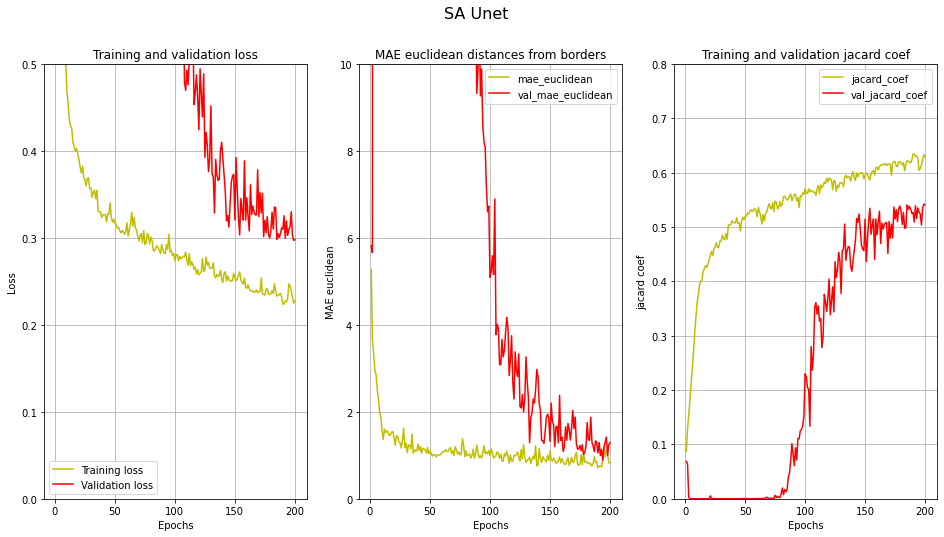

In [15]:
plot_history(history_sa_unet1, "SA Unet")

In [16]:
model_sa_unet1.evaluate(X_val, y_val)

1/1 [==============================] - 0s 353ms/step - loss: 0.2979 - mae_euclidean: 1.2925 - jacard_coef: 0.5409


[0.2979312539100647, 1.292516827583313, 0.540920078754425]

## Attention UNet model trials

In [17]:
# tf.keras.backend.clear_session()

In [18]:
# Attention Unet1
tf.random.set_seed(14)
model_att_unet1 = Attention_UNet(input_shape)
model_att_unet1.compile(optimizer=Adam(learning_rate=1e-2),
                         loss = dice_coef_loss,
                         metrics=[mae_euclidean, jacard_coef]
                         )
start = time.time()
history_att_unet1 = model_att_unet1.fit(X_train, y_train,
                                    validation_data = (X_val, y_val),
                                    batch_size = 2,
                                    epochs=50
                                   )
print(f"Model trained for {time.time() - start}s")
model_att_unet1.save("2022-02-17 Att-UNet1 50epochs.hdf5")

Epoch 1/50
16/16 [==============================] - 19s 455ms/step - loss: 0.8100 - mae_euclidean: 4.1651 - jacard_coef: 0.1062 - val_loss: 0.9816 - val_mae_euclidean: 63.0797 - val_jacard_coef: 0.0093
Epoch 2/50
16/16 [==============================] - 7s 418ms/step - loss: 0.7642 - mae_euclidean: 3.8893 - jacard_coef: 0.1349 - val_loss: 0.8609 - val_mae_euclidean: 6.2517 - val_jacard_coef: 0.0759
Epoch 3/50
16/16 [==============================] - 7s 419ms/step - loss: 0.7339 - mae_euclidean: 3.7794 - jacard_coef: 0.1547 - val_loss: 0.9324 - val_mae_euclidean: 57.5636 - val_jacard_coef: 0.0351
Epoch 4/50
16/16 [==============================] - 7s 419ms/step - loss: 0.7081 - mae_euclidean: 3.0676 - jacard_coef: 0.1723 - val_loss: 0.9998 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 1.8732e-04
Epoch 5/50
16/16 [==============================] - 7s 418ms/step - loss: 0.6804 - mae_euclidean: 2.9842 - jacard_coef: 0.1919 - val_loss: 0.8808 - val_mae_euclidean: 9223371

16/16 [==============================] - 7s 421ms/step - loss: 0.2694 - mae_euclidean: 0.7487 - jacard_coef: 0.5773 - val_loss: 0.3585 - val_mae_euclidean: 2.3875 - val_jacard_coef: 0.4733
Epoch 42/50
16/16 [==============================] - 7s 422ms/step - loss: 0.2782 - mae_euclidean: 0.7625 - jacard_coef: 0.5658 - val_loss: 0.4312 - val_mae_euclidean: 3.0479 - val_jacard_coef: 0.3982
Epoch 43/50
16/16 [==============================] - 7s 423ms/step - loss: 0.2548 - mae_euclidean: 0.8217 - jacard_coef: 0.5949 - val_loss: 0.3958 - val_mae_euclidean: 2.0207 - val_jacard_coef: 0.4332
Epoch 44/50
16/16 [==============================] - 7s 422ms/step - loss: 0.2557 - mae_euclidean: 0.6456 - jacard_coef: 0.5945 - val_loss: 0.3771 - val_mae_euclidean: 1.4731 - val_jacard_coef: 0.4542
Epoch 45/50
16/16 [==============================] - 7s 423ms/step - loss: 0.2494 - mae_euclidean: 0.6942 - jacard_coef: 0.6019 - val_loss: 0.3663 - val_mae_euclidean: 1.3279 - val_jacard_coef: 0.4660
Epoch 4

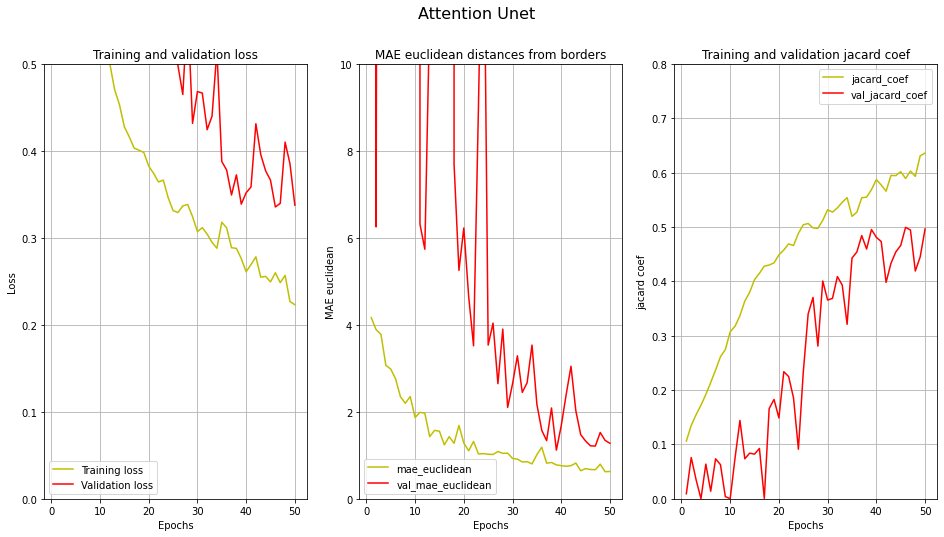

In [19]:
plot_history(history_att_unet1, "Attention Unet")

In [20]:
# additional trainning with smaller learning rate
model_att_unet1.compile(optimizer=Adam(learning_rate=1e-3),
                         loss = dice_coef_loss,
                         metrics=[mae_euclidean, jacard_coef]
                         )
start = time.time()
history_att_unet1a = model_att_unet1.fit(X_train, y_train,
                                        validation_data = (X_val, y_val),
                                        batch_size = 2,
                                        epochs=25
                                       )
print(f"Model trained for {time.time() - start}s")
model_att_unet1.save("2022-02-17 Att-UNet1a 50+25epochs.hdf5")

Epoch 1/25
16/16 [==============================] - 11s 453ms/step - loss: 0.2119 - mae_euclidean: 0.5784 - jacard_coef: 0.6516 - val_loss: 0.3437 - val_mae_euclidean: 1.2986 - val_jacard_coef: 0.4897
Epoch 2/25
16/16 [==============================] - 7s 415ms/step - loss: 0.1986 - mae_euclidean: 0.5058 - jacard_coef: 0.6698 - val_loss: 0.3321 - val_mae_euclidean: 1.2732 - val_jacard_coef: 0.5026
Epoch 3/25
16/16 [==============================] - 7s 417ms/step - loss: 0.1919 - mae_euclidean: 0.5179 - jacard_coef: 0.6790 - val_loss: 0.3273 - val_mae_euclidean: 1.2761 - val_jacard_coef: 0.5082
Epoch 4/25
16/16 [==============================] - 7s 419ms/step - loss: 0.1882 - mae_euclidean: 0.5066 - jacard_coef: 0.6842 - val_loss: 0.3243 - val_mae_euclidean: 1.1886 - val_jacard_coef: 0.5121
Epoch 5/25
16/16 [==============================] - 7s 419ms/step - loss: 0.1818 - mae_euclidean: 0.4620 - jacard_coef: 0.6929 - val_loss: 0.3299 - val_mae_euclidean: 1.2154 - val_jacard_coef: 0.5055

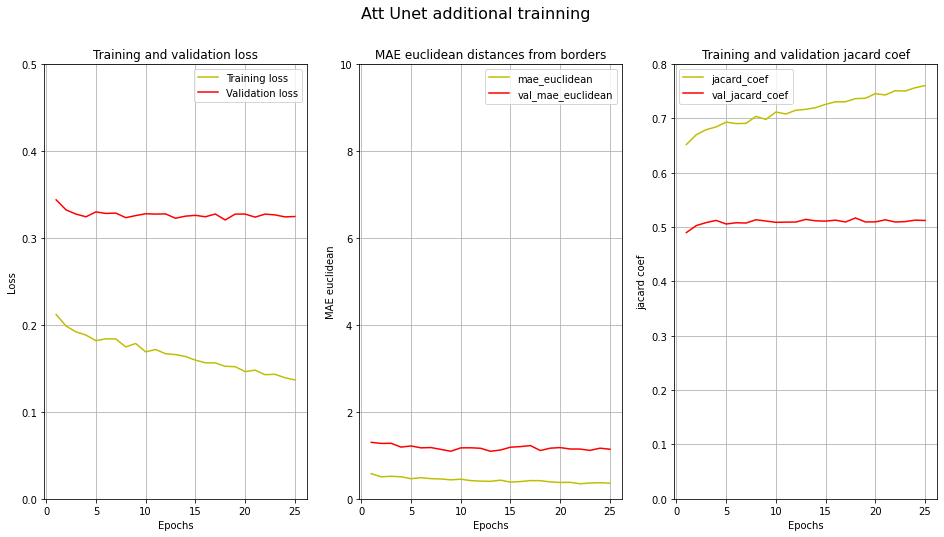

In [21]:
plot_history(history_att_unet1a, "Att Unet additional trainning")

In [22]:
model_att_unet1.evaluate(X_val, y_val)

1/1 [==============================] - 7s 7s/step - loss: 0.3036 - mae_euclidean: 1.1399 - jacard_coef: 0.5342


[0.3036247491836548, 1.139896035194397, 0.5341904759407043]

## UNet (classic) model trials

In [23]:
# tf.keras.backend.clear_session()

In [24]:
# Classic Unet1
tf.random.set_seed(14)
model_unet1 = UNet(input_shape)
model_unet1.compile(optimizer=Adam(learning_rate=1e-2),
                     loss = dice_coef_loss,
                     metrics=[mae_euclidean, jacard_coef]
                     )
start = time.time()
history_unet1 = model_unet1.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                batch_size = 4,
                                epochs=200
                               )
print(f"Model trained for {time.time() - start}s")
model_unet1.save("2022-02-17 UNet1 200epochs.hdf5")

Epoch 1/200
8/8 [==============================] - 13s 689ms/step - loss: 0.8266 - mae_euclidean: 4.5184 - jacard_coef: 0.0958 - val_loss: 0.8604 - val_mae_euclidean: 6.2757 - val_jacard_coef: 0.0761
Epoch 2/200
8/8 [==============================] - 5s 617ms/step - loss: 0.7856 - mae_euclidean: 3.6526 - jacard_coef: 0.1209 - val_loss: 0.8619 - val_mae_euclidean: 6.3189 - val_jacard_coef: 0.0753
Epoch 3/200
8/8 [==============================] - 5s 614ms/step - loss: 0.7602 - mae_euclidean: 3.3592 - jacard_coef: 0.1364 - val_loss: 0.8619 - val_mae_euclidean: 6.3222 - val_jacard_coef: 0.0753
Epoch 4/200
8/8 [==============================] - 5s 617ms/step - loss: 0.7461 - mae_euclidean: 3.4805 - jacard_coef: 0.1458 - val_loss: 0.9373 - val_mae_euclidean: 56.7043 - val_jacard_coef: 0.0326
Epoch 5/200
8/8 [==============================] - 5s 617ms/step - loss: 0.7336 - mae_euclidean: 3.3536 - jacard_coef: 0.1546 - val_loss: 0.9834 - val_mae_euclidean: 62.6911 - val_jacard_coef: 0.0084
Ep

Epoch 41/200
8/8 [==============================] - 5s 607ms/step - loss: 0.3415 - mae_euclidean: 0.9575 - jacard_coef: 0.4916 - val_loss: 0.8777 - val_mae_euclidean: 8.5606 - val_jacard_coef: 0.0652
Epoch 42/200
8/8 [==============================] - 5s 609ms/step - loss: 0.3422 - mae_euclidean: 1.1084 - jacard_coef: 0.4911 - val_loss: 0.8497 - val_mae_euclidean: 8.1112 - val_jacard_coef: 0.0813
Epoch 43/200
8/8 [==============================] - 5s 609ms/step - loss: 0.3271 - mae_euclidean: 0.9384 - jacard_coef: 0.5079 - val_loss: 0.8187 - val_mae_euclidean: 7.2131 - val_jacard_coef: 0.0998
Epoch 44/200
8/8 [==============================] - 5s 609ms/step - loss: 0.3279 - mae_euclidean: 1.0506 - jacard_coef: 0.5073 - val_loss: 0.7975 - val_mae_euclidean: 6.3796 - val_jacard_coef: 0.1129
Epoch 45/200
8/8 [==============================] - 5s 608ms/step - loss: 0.3303 - mae_euclidean: 0.9820 - jacard_coef: 0.5056 - val_loss: 0.8020 - val_mae_euclidean: 6.1947 - val_jacard_coef: 0.1102


Epoch 82/200
8/8 [==============================] - 5s 609ms/step - loss: 0.1739 - mae_euclidean: 0.5638 - jacard_coef: 0.7045 - val_loss: 0.3749 - val_mae_euclidean: 1.5853 - val_jacard_coef: 0.4554
Epoch 83/200
8/8 [==============================] - 5s 607ms/step - loss: 0.1579 - mae_euclidean: 0.4554 - jacard_coef: 0.7274 - val_loss: 0.3806 - val_mae_euclidean: 1.5563 - val_jacard_coef: 0.4495
Epoch 84/200
8/8 [==============================] - 5s 608ms/step - loss: 0.1583 - mae_euclidean: 0.4432 - jacard_coef: 0.7271 - val_loss: 0.3628 - val_mae_euclidean: 1.3823 - val_jacard_coef: 0.4686
Epoch 85/200
8/8 [==============================] - 5s 610ms/step - loss: 0.1730 - mae_euclidean: 0.5104 - jacard_coef: 0.7056 - val_loss: 0.3454 - val_mae_euclidean: 1.1774 - val_jacard_coef: 0.4876
Epoch 86/200
8/8 [==============================] - 5s 607ms/step - loss: 0.1663 - mae_euclidean: 0.5925 - jacard_coef: 0.7153 - val_loss: 0.3511 - val_mae_euclidean: 1.3100 - val_jacard_coef: 0.4815


Epoch 123/200
8/8 [==============================] - 5s 609ms/step - loss: 0.0542 - mae_euclidean: 0.1920 - jacard_coef: 0.8977 - val_loss: 0.3573 - val_mae_euclidean: 1.0320 - val_jacard_coef: 0.4749
Epoch 124/200
8/8 [==============================] - 5s 613ms/step - loss: 0.0504 - mae_euclidean: 0.2032 - jacard_coef: 0.9042 - val_loss: 0.3450 - val_mae_euclidean: 1.0372 - val_jacard_coef: 0.4884
Epoch 125/200
8/8 [==============================] - 5s 613ms/step - loss: 0.0505 - mae_euclidean: 0.1748 - jacard_coef: 0.9039 - val_loss: 0.3523 - val_mae_euclidean: 1.1676 - val_jacard_coef: 0.4806
Epoch 126/200
8/8 [==============================] - 5s 611ms/step - loss: 0.0465 - mae_euclidean: 0.1763 - jacard_coef: 0.9113 - val_loss: 0.3408 - val_mae_euclidean: 0.8436 - val_jacard_coef: 0.4929
Epoch 127/200
8/8 [==============================] - 5s 614ms/step - loss: 0.0455 - mae_euclidean: 0.1743 - jacard_coef: 0.9130 - val_loss: 0.3517 - val_mae_euclidean: 1.2290 - val_jacard_coef: 0.

Epoch 164/200
8/8 [==============================] - 5s 613ms/step - loss: 0.0251 - mae_euclidean: 0.1016 - jacard_coef: 0.9511 - val_loss: 0.3499 - val_mae_euclidean: 0.8847 - val_jacard_coef: 0.4834
Epoch 165/200
8/8 [==============================] - 5s 611ms/step - loss: 0.0249 - mae_euclidean: 0.1012 - jacard_coef: 0.9513 - val_loss: 0.3468 - val_mae_euclidean: 0.9378 - val_jacard_coef: 0.4871
Epoch 166/200
8/8 [==============================] - 5s 612ms/step - loss: 0.0259 - mae_euclidean: 0.1015 - jacard_coef: 0.9496 - val_loss: 0.3452 - val_mae_euclidean: 0.8768 - val_jacard_coef: 0.4884
Epoch 167/200
8/8 [==============================] - 5s 609ms/step - loss: 0.0249 - mae_euclidean: 0.1012 - jacard_coef: 0.9514 - val_loss: 0.3467 - val_mae_euclidean: 0.9784 - val_jacard_coef: 0.4867
Epoch 168/200
8/8 [==============================] - 5s 608ms/step - loss: 0.0255 - mae_euclidean: 0.1001 - jacard_coef: 0.9505 - val_loss: 0.3452 - val_mae_euclidean: 0.8669 - val_jacard_coef: 0.

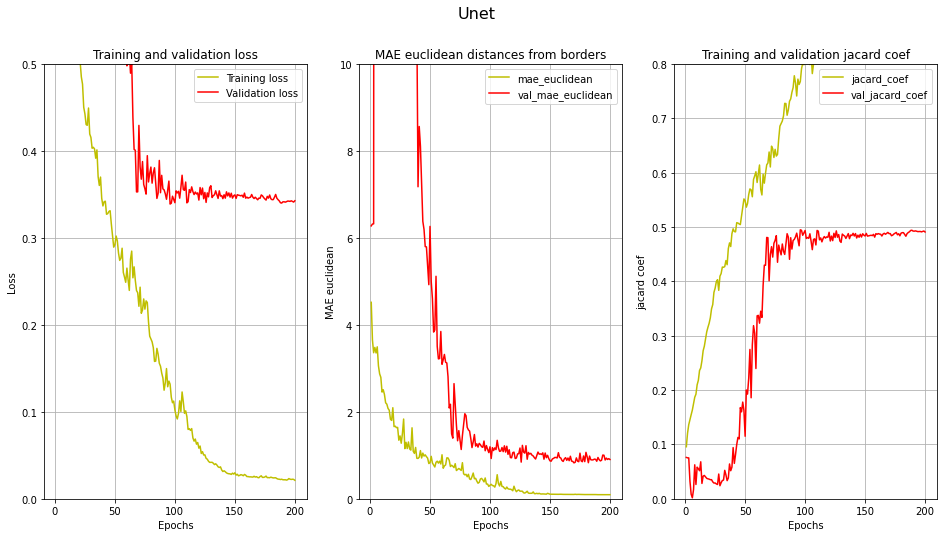

In [25]:
plot_history(history_unet1, "Unet")

In [26]:
model_unet1.evaluate(X_val, y_val)

1/1 [==============================] - 1s 977ms/step - loss: 0.3261 - mae_euclidean: 0.9038 - jacard_coef: 0.5082


[0.3261321187019348, 0.9037566781044006, 0.5081525444984436]

## Attention residual UNet model trials

In [31]:
tf.keras.backend.clear_session()

In [14]:
# Attention residual Unet1
tf.random.set_seed(14)
model_att_res_unet1 = Attention_ResUNet(input_shape)
model_att_res_unet1.compile(optimizer=Adam(learning_rate=1e-2),
                     loss = dice_coef_loss,
                     metrics=[mae_euclidean, jacard_coef]
                     )
start = time.time()
history_att_res_unet1 = model_att_res_unet1.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                batch_size = 2,
                                epochs=100
                               )
print(f"Model trained for {time.time() - start}s")
model_att_res_unet1.save("2022-02-17 att_res_UNet1 100epochs.hdf5")

Epoch 1/100
16/16 [==============================] - 21s 465ms/step - loss: 0.8110 - mae_euclidean: 3.5976 - jacard_coef: 0.1057 - val_loss: 0.8614 - val_mae_euclidean: 6.3043 - val_jacard_coef: 0.0756
Epoch 2/100
16/16 [==============================] - 7s 419ms/step - loss: 0.7632 - mae_euclidean: 3.8068 - jacard_coef: 0.1357 - val_loss: 0.9898 - val_mae_euclidean: 120.9765 - val_jacard_coef: 0.0052
Epoch 3/100
16/16 [==============================] - 7s 417ms/step - loss: 0.7324 - mae_euclidean: 3.6451 - jacard_coef: 0.1557 - val_loss: 0.9974 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 0.0014
Epoch 4/100
16/16 [==============================] - 7s 418ms/step - loss: 0.7036 - mae_euclidean: 3.0018 - jacard_coef: 0.1753 - val_loss: 0.8520 - val_mae_euclidean: 6.2725 - val_jacard_coef: 0.0811
Epoch 5/100
16/16 [==============================] - 7s 418ms/step - loss: 0.6764 - mae_euclidean: 2.7265 - jacard_coef: 0.1947 - val_loss: 0.8727 - val_mae_euclidean: 41.858

16/16 [==============================] - 8s 477ms/step - loss: 0.1556 - mae_euclidean: 0.2970 - jacard_coef: 0.7312 - val_loss: 0.3962 - val_mae_euclidean: 1.3295 - val_jacard_coef: 0.4326
Epoch 42/100
16/16 [==============================] - 8s 478ms/step - loss: 0.1609 - mae_euclidean: 0.3339 - jacard_coef: 0.7234 - val_loss: 0.3798 - val_mae_euclidean: 1.1066 - val_jacard_coef: 0.4504
Epoch 43/100
16/16 [==============================] - 8s 477ms/step - loss: 0.1460 - mae_euclidean: 0.3090 - jacard_coef: 0.7455 - val_loss: 0.3733 - val_mae_euclidean: 1.1689 - val_jacard_coef: 0.4572
Epoch 44/100
16/16 [==============================] - 8s 476ms/step - loss: 0.1542 - mae_euclidean: 0.3197 - jacard_coef: 0.7339 - val_loss: 0.4212 - val_mae_euclidean: 1.2646 - val_jacard_coef: 0.4105
Epoch 45/100
16/16 [==============================] - 8s 478ms/step - loss: 0.1514 - mae_euclidean: 0.2985 - jacard_coef: 0.7378 - val_loss: 0.4044 - val_mae_euclidean: 1.2754 - val_jacard_coef: 0.4258
Epo

Epoch 82/100
16/16 [==============================] - 8s 476ms/step - loss: 0.0441 - mae_euclidean: 0.1066 - jacard_coef: 0.9155 - val_loss: 0.3689 - val_mae_euclidean: 1.0511 - val_jacard_coef: 0.4619
Epoch 83/100
16/16 [==============================] - 8s 476ms/step - loss: 0.0414 - mae_euclidean: 0.1047 - jacard_coef: 0.9206 - val_loss: 0.3570 - val_mae_euclidean: 0.9969 - val_jacard_coef: 0.4746
Epoch 84/100
16/16 [==============================] - 8s 476ms/step - loss: 0.0389 - mae_euclidean: 0.1018 - jacard_coef: 0.9252 - val_loss: 0.3520 - val_mae_euclidean: 0.9345 - val_jacard_coef: 0.4806
Epoch 85/100
16/16 [==============================] - 8s 476ms/step - loss: 0.0397 - mae_euclidean: 0.1069 - jacard_coef: 0.9237 - val_loss: 0.3639 - val_mae_euclidean: 0.9792 - val_jacard_coef: 0.4675
Epoch 86/100
16/16 [==============================] - 8s 476ms/step - loss: 0.0376 - mae_euclidean: 0.1040 - jacard_coef: 0.9276 - val_loss: 0.3627 - val_mae_euclidean: 1.0703 - val_jacard_coe

C:\Users\a1048794\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


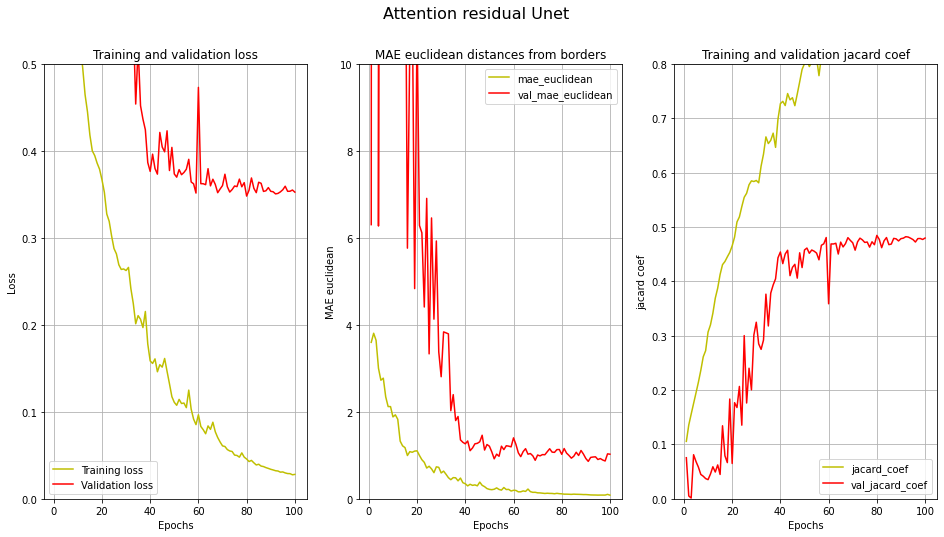

In [15]:
plot_history(history_att_res_unet1, "Attention residual Unet")

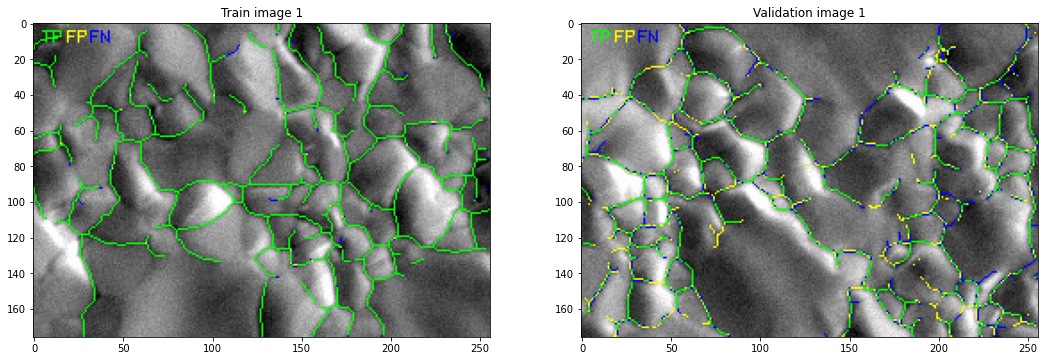

In [16]:
plot_train_val(model_att_res_unet1, 1, 1)

## SA Unet tuning - block_size, keep_prob, start_neurons

The results indicate the smallest model, SA UNet gives the best Jacard scores. It is supposed that the small number of channels in the network is the reason for better generalization. Bayesian optimization will be performed.

In [17]:
def model_builder_SA_UNet(hp):
    hp_block_size =  hp.Int('block_size', min_value=15, max_value=35, step=5) # bigger - more regularization
    hp_keep_prob = hp.Float('keep_prob', min_value=0.5, max_value=0.9, step=0.1)
    hp_start_neurons = hp.Int('start_neurons', min_value=10, max_value=30, step=5)
    
    model = SA_UNet(input_shape, block_size=hp_block_size, keep_prob=hp_keep_prob, start_neurons=hp_start_neurons)
    
    model.compile(optimizer = Adam(learning_rate = 1e-2),
                 loss = dice_coef_loss,
                 metrics=[mae_euclidean, jacard_coef])

    return model

In [18]:
tuner = kt.BayesianOptimization(model_builder_SA_UNet,
                                 objective = kt.Objective("val_mae_euclidean", direction='min'), 
                                 max_trials=16,
                                 seed = 14,
                                 directory=os.path.normpath('C:/keras_tuner'),
                                 project_name='2022-02-16_SA_UNet_tune1')

INFO:tensorflow:Reloading Oracle from existing project C:\keras_tuner\2022-02-16_SA_UNet_tune1\oracle.json
INFO:tensorflow:Reloading Tuner from C:\keras_tuner\2022-02-16_SA_UNet_tune1\tuner0.json


In [19]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_jacard_coef',
#                                               mode='max',
#                                               patience=30)

In [20]:
tf.random.set_seed(14)
tuner.search(X_train, y_train,
             validation_data = (X_val, y_val),
             #callbacks=[stop_early],
             batch_size = 8,
             epochs=200
            ) 

INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary(num_trials=5)

Results summary
Results in C:\keras_tuner\2022-02-16_SA_UNet_tune1
Showing 5 best trials
Objective(name='val_mae_euclidean', direction='min')
Trial summary
Hyperparameters:
block_size: 25
keep_prob: 0.7999999999999999
start_neurons: 20
Score: 0.8768714666366577
Trial summary
Hyperparameters:
block_size: 35
keep_prob: 0.8999999999999999
start_neurons: 30
Score: 0.9034335613250732
Trial summary
Hyperparameters:
block_size: 20
keep_prob: 0.8999999999999999
start_neurons: 30
Score: 0.9521717429161072
Trial summary
Hyperparameters:
block_size: 35
keep_prob: 0.8999999999999999
start_neurons: 10
Score: 0.9712845087051392
Trial summary
Hyperparameters:
block_size: 30
keep_prob: 0.8999999999999999
start_neurons: 20
Score: 0.97222501039505


Top 5 parameters produce similar scores with wide range of parameters (only keep_prob is always on the upper end). Block size in top 3 models varies between 25, 35, 20 producing objective within the noise.

In [22]:
# SA Unet2
# increasing the block size from 19 to 25 as recomended by the tuner
tf.random.set_seed(14)
model_sa_unet2 = SA_UNet(input_shape, block_size=25, keep_prob=0.8, start_neurons=20)
model_sa_unet2.compile(optimizer=Adam(learning_rate=1e-2),
                         loss = dice_coef_loss,
                         metrics=[mae_euclidean, jacard_coef]
                         )
start = time.time()
history_sa_unet2 = model_sa_unet2.fit(X_train, y_train,
                                    validation_data = (X_val, y_val),
                                    batch_size = 8, # no resources for 16
                                    epochs=200
                                   )
print(f"Model trained for {time.time() - start}s")
model_sa_unet2.save("2022-02-17 SA-UNet2 200epochs.hdf5")

Epoch 1/200
4/4 [==============================] - 8s 565ms/step - loss: 0.8421 - mae_euclidean: 5.2554 - jacard_coef: 0.0865 - val_loss: 0.8597 - val_mae_euclidean: 6.0402 - val_jacard_coef: 0.0755
Epoch 2/200
4/4 [==============================] - 2s 463ms/step - loss: 0.7753 - mae_euclidean: 3.5628 - jacard_coef: 0.1268 - val_loss: 0.8938 - val_mae_euclidean: 5.5043 - val_jacard_coef: 0.0561
Epoch 3/200
4/4 [==============================] - 2s 462ms/step - loss: 0.7370 - mae_euclidean: 3.2331 - jacard_coef: 0.1515 - val_loss: 0.9131 - val_mae_euclidean: 5.3065 - val_jacard_coef: 0.0454
Epoch 4/200
4/4 [==============================] - 2s 464ms/step - loss: 0.6959 - mae_euclidean: 2.9099 - jacard_coef: 0.1794 - val_loss: 0.9897 - val_mae_euclidean: 62.5067 - val_jacard_coef: 0.0052
Epoch 5/200
4/4 [==============================] - 2s 464ms/step - loss: 0.6573 - mae_euclidean: 2.9397 - jacard_coef: 0.2074 - val_loss: 0.8808 - val_mae_euclidean: 5.6331 - val_jacard_coef: 0.0634
Epoc

4/4 [==============================] - 2s 464ms/step - loss: 0.3284 - mae_euclidean: 1.1075 - jacard_coef: 0.5058 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 5.1751e-05
Epoch 39/200
4/4 [==============================] - 2s 470ms/step - loss: 0.3216 - mae_euclidean: 1.1532 - jacard_coef: 0.5133 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 4.4959e-05
Epoch 40/200
4/4 [==============================] - 2s 464ms/step - loss: 0.3224 - mae_euclidean: 1.2902 - jacard_coef: 0.5125 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 5.0660e-05
Epoch 41/200
4/4 [==============================] - 2s 460ms/step - loss: 0.3214 - mae_euclidean: 1.0837 - jacard_coef: 0.5138 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 4.9514e-05
Epoch 42/200
4/4 [==============================] - 2s 463ms/step - loss: 0.3226 - mae_euclidean: 1.2557 - jacard_coef: 0

4/4 [==============================] - 2s 464ms/step - loss: 0.2870 - mae_euclidean: 0.9634 - jacard_coef: 0.5541 - val_loss: 0.9926 - val_mae_euclidean: 51.5498 - val_jacard_coef: 0.0037
Epoch 76/200
4/4 [==============================] - 2s 464ms/step - loss: 0.2862 - mae_euclidean: 0.9544 - jacard_coef: 0.5551 - val_loss: 0.9918 - val_mae_euclidean: 40.8082 - val_jacard_coef: 0.0041
Epoch 77/200
4/4 [==============================] - 2s 463ms/step - loss: 0.3021 - mae_euclidean: 1.3926 - jacard_coef: 0.5371 - val_loss: 0.9842 - val_mae_euclidean: 36.0560 - val_jacard_coef: 0.0080
Epoch 78/200
4/4 [==============================] - 2s 464ms/step - loss: 0.2994 - mae_euclidean: 1.0757 - jacard_coef: 0.5392 - val_loss: 0.9969 - val_mae_euclidean: 2305842871774740480.0000 - val_jacard_coef: 0.0016
Epoch 79/200
4/4 [==============================] - 2s 463ms/step - loss: 0.2879 - mae_euclidean: 0.9651 - jacard_coef: 0.5531 - val_loss: 0.9957 - val_mae_euclidean: 51.9813 - val_jacard_coef

Epoch 116/200
4/4 [==============================] - 2s 465ms/step - loss: 0.2572 - mae_euclidean: 0.8343 - jacard_coef: 0.5911 - val_loss: 0.5553 - val_mae_euclidean: 4.2329 - val_jacard_coef: 0.2859
Epoch 117/200
4/4 [==============================] - 2s 464ms/step - loss: 0.2573 - mae_euclidean: 0.9376 - jacard_coef: 0.5910 - val_loss: 0.5808 - val_mae_euclidean: 4.5407 - val_jacard_coef: 0.2652
Epoch 118/200
4/4 [==============================] - 2s 490ms/step - loss: 0.2503 - mae_euclidean: 0.8115 - jacard_coef: 0.5997 - val_loss: 0.4867 - val_mae_euclidean: 3.3884 - val_jacard_coef: 0.3452
Epoch 119/200
4/4 [==============================] - 2s 490ms/step - loss: 0.2535 - mae_euclidean: 0.9091 - jacard_coef: 0.5956 - val_loss: 0.5432 - val_mae_euclidean: 4.1913 - val_jacard_coef: 0.2960
Epoch 120/200
4/4 [==============================] - 2s 493ms/step - loss: 0.2477 - mae_euclidean: 0.8881 - jacard_coef: 0.6031 - val_loss: 0.5000 - val_mae_euclidean: 3.5178 - val_jacard_coef: 0.

Epoch 157/200
4/4 [==============================] - 2s 490ms/step - loss: 0.2259 - mae_euclidean: 0.7292 - jacard_coef: 0.6317 - val_loss: 0.3199 - val_mae_euclidean: 1.1489 - val_jacard_coef: 0.5153
Epoch 158/200
4/4 [==============================] - 2s 488ms/step - loss: 0.2350 - mae_euclidean: 0.8872 - jacard_coef: 0.6195 - val_loss: 0.3288 - val_mae_euclidean: 1.1481 - val_jacard_coef: 0.5051
Epoch 159/200
4/4 [==============================] - 2s 489ms/step - loss: 0.2282 - mae_euclidean: 0.7770 - jacard_coef: 0.6286 - val_loss: 0.3229 - val_mae_euclidean: 1.1743 - val_jacard_coef: 0.5118
Epoch 160/200
4/4 [==============================] - 2s 489ms/step - loss: 0.2243 - mae_euclidean: 0.8462 - jacard_coef: 0.6337 - val_loss: 0.3185 - val_mae_euclidean: 1.1317 - val_jacard_coef: 0.5169
Epoch 161/200
4/4 [==============================] - 2s 489ms/step - loss: 0.2202 - mae_euclidean: 0.7995 - jacard_coef: 0.6392 - val_loss: 0.3170 - val_mae_euclidean: 1.1560 - val_jacard_coef: 0.

Epoch 198/200
4/4 [==============================] - 2s 488ms/step - loss: 0.2019 - mae_euclidean: 1.1415 - jacard_coef: 0.6641 - val_loss: 0.3451 - val_mae_euclidean: 2.2220 - val_jacard_coef: 0.4869
Epoch 199/200
4/4 [==============================] - 2s 488ms/step - loss: 0.1958 - mae_euclidean: 0.7096 - jacard_coef: 0.6726 - val_loss: 0.3542 - val_mae_euclidean: 1.5990 - val_jacard_coef: 0.4769
Epoch 200/200
4/4 [==============================] - 2s 488ms/step - loss: 0.1968 - mae_euclidean: 0.7984 - jacard_coef: 0.6712 - val_loss: 0.3165 - val_mae_euclidean: 1.1171 - val_jacard_coef: 0.5191
Model trained for 382.39845991134644s


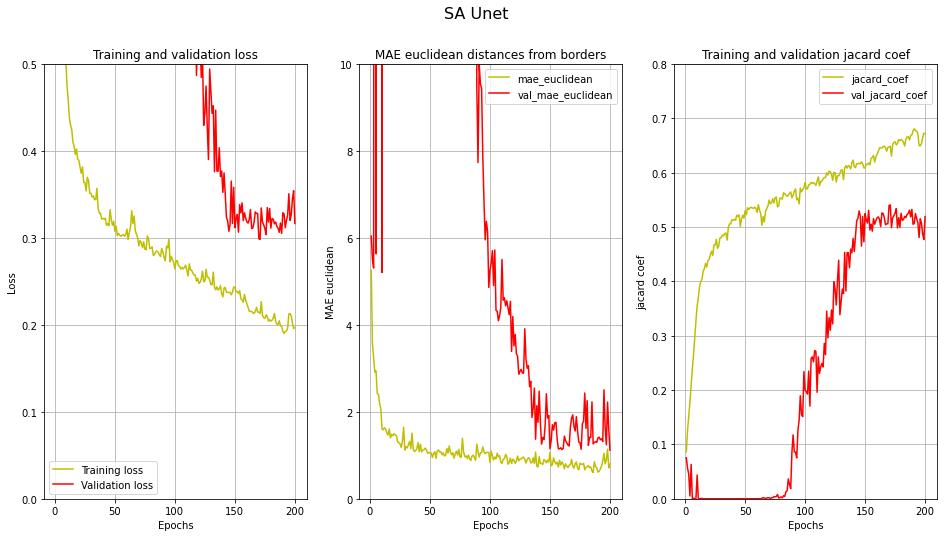

In [23]:
plot_history(history_sa_unet2, "SA Unet")

In [24]:
model_sa_unet2.evaluate(X_val, y_val)

1/1 [==============================] - 0s 352ms/step - loss: 0.3165 - mae_euclidean: 1.1171 - jacard_coef: 0.5191


[0.3165448307991028, 1.1170706748962402, 0.5191344618797302]

Small trend for increasing validation loss - a sign for overfitting. The val_mae_euclidean (the objective of the tune) is smaller (good), but the jacard is significantly smaller (not good) than model_sa_unet1.

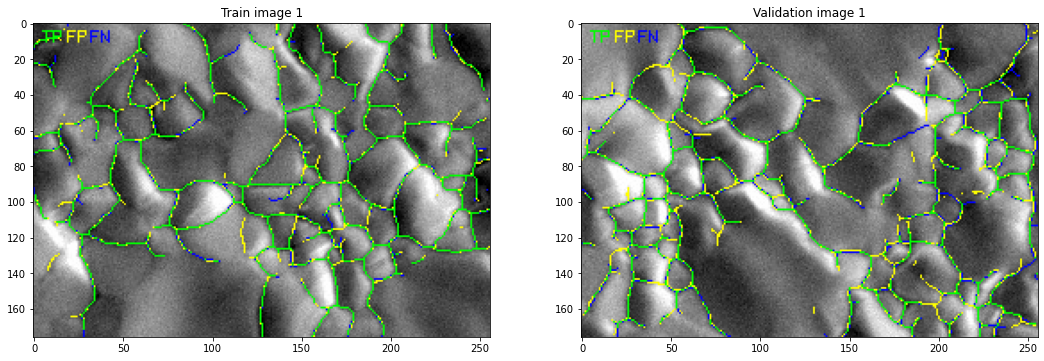

In [25]:
plot_train_val(model_sa_unet2, 1, 1)

In [26]:
# continue trainning with smaller learning rate
model_sa_unet2a = tf.keras.models.clone_model(model_sa_unet2)
model_sa_unet2a.set_weights(model_sa_unet2.get_weights())
model_sa_unet2a.compile(optimizer=Adam(learning_rate=1e-3),
                         loss = dice_coef_loss,
                         metrics=[mae_euclidean, jacard_coef]
                         )
history_sa_unet2a = model_sa_unet2a.fit(X_train, y_train,
                                    validation_data = (X_val, y_val),
                                    batch_size = 8,
                                    epochs=100
                                   )
model_sa_unet2a.save("2022-02-17 best SA-UNet2a 200+100epochs.hdf5")

Epoch 1/100
4/4 [==============================] - 6s 584ms/step - loss: 0.1958 - mae_euclidean: 0.7189 - jacard_coef: 0.6725 - val_loss: 0.3379 - val_mae_euclidean: 1.1639 - val_jacard_coef: 0.4949
Epoch 2/100
4/4 [==============================] - 2s 487ms/step - loss: 0.1888 - mae_euclidean: 0.6815 - jacard_coef: 0.6825 - val_loss: 0.3262 - val_mae_euclidean: 1.2222 - val_jacard_coef: 0.5081
Epoch 3/100
4/4 [==============================] - 2s 487ms/step - loss: 0.1839 - mae_euclidean: 0.5711 - jacard_coef: 0.6896 - val_loss: 0.3140 - val_mae_euclidean: 1.2105 - val_jacard_coef: 0.5221
Epoch 4/100
4/4 [==============================] - 2s 488ms/step - loss: 0.1813 - mae_euclidean: 0.7065 - jacard_coef: 0.6931 - val_loss: 0.3113 - val_mae_euclidean: 1.2141 - val_jacard_coef: 0.5252
Epoch 5/100
4/4 [==============================] - 2s 488ms/step - loss: 0.1842 - mae_euclidean: 0.7839 - jacard_coef: 0.6890 - val_loss: 0.3112 - val_mae_euclidean: 1.1063 - val_jacard_coef: 0.5254
Epoch

4/4 [==============================] - 2s 493ms/step - loss: 0.1683 - mae_euclidean: 0.6119 - jacard_coef: 0.7119 - val_loss: 0.3340 - val_mae_euclidean: 1.6375 - val_jacard_coef: 0.4993
Epoch 43/100
4/4 [==============================] - 2s 493ms/step - loss: 0.1648 - mae_euclidean: 0.5396 - jacard_coef: 0.7171 - val_loss: 0.3371 - val_mae_euclidean: 1.6538 - val_jacard_coef: 0.4958
Epoch 44/100
4/4 [==============================] - 2s 493ms/step - loss: 0.1673 - mae_euclidean: 0.6650 - jacard_coef: 0.7136 - val_loss: 0.3343 - val_mae_euclidean: 1.6512 - val_jacard_coef: 0.4989
Epoch 45/100
4/4 [==============================] - 2s 493ms/step - loss: 0.1656 - mae_euclidean: 0.6421 - jacard_coef: 0.7160 - val_loss: 0.3302 - val_mae_euclidean: 1.6247 - val_jacard_coef: 0.5036
Epoch 46/100
4/4 [==============================] - 2s 493ms/step - loss: 0.1738 - mae_euclidean: 0.6574 - jacard_coef: 0.7041 - val_loss: 0.3302 - val_mae_euclidean: 1.6432 - val_jacard_coef: 0.5035
Epoch 47/100


4/4 [==============================] - 2s 490ms/step - loss: 0.1605 - mae_euclidean: 0.5758 - jacard_coef: 0.7235 - val_loss: 0.3299 - val_mae_euclidean: 1.3340 - val_jacard_coef: 0.5039
Epoch 84/100
4/4 [==============================] - 2s 491ms/step - loss: 0.1598 - mae_euclidean: 0.5041 - jacard_coef: 0.7246 - val_loss: 0.3248 - val_mae_euclidean: 1.3433 - val_jacard_coef: 0.5097
Epoch 85/100
4/4 [==============================] - 2s 490ms/step - loss: 0.1602 - mae_euclidean: 0.5661 - jacard_coef: 0.7238 - val_loss: 0.3299 - val_mae_euclidean: 1.2402 - val_jacard_coef: 0.5038
Epoch 86/100
4/4 [==============================] - 2s 490ms/step - loss: 0.1613 - mae_euclidean: 0.5440 - jacard_coef: 0.7223 - val_loss: 0.3357 - val_mae_euclidean: 1.3729 - val_jacard_coef: 0.4974
Epoch 87/100
4/4 [==============================] - 2s 489ms/step - loss: 0.1588 - mae_euclidean: 0.5525 - jacard_coef: 0.7260 - val_loss: 0.3378 - val_mae_euclidean: 1.6419 - val_jacard_coef: 0.4950
Epoch 88/100


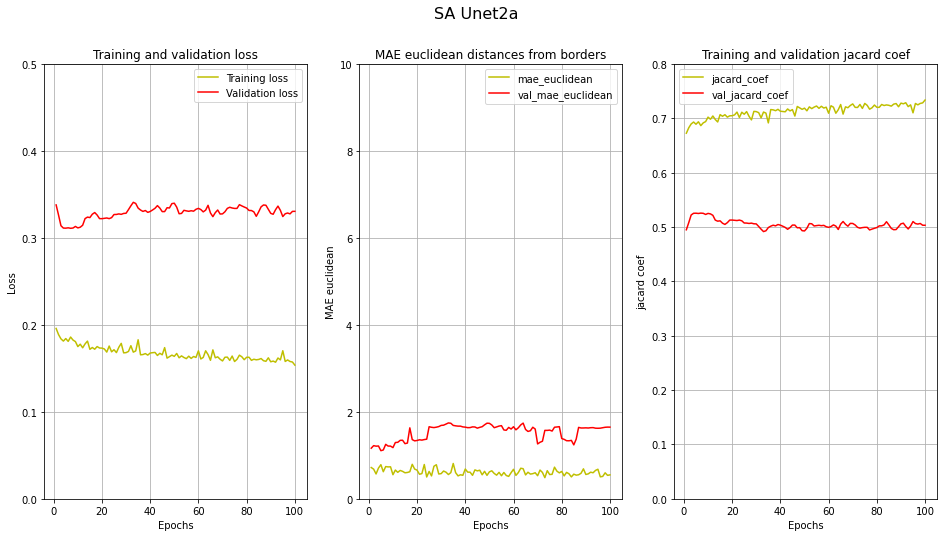

In [27]:
plot_history(history_sa_unet2a, "SA Unet2a")

No further improvement achieved with the smaller learning rate.  No significant over fitting.

In [28]:
model_sa_unet2a.evaluate(X_val, y_val)

1/1 [==============================] - 0s 350ms/step - loss: 0.3305 - mae_euclidean: 1.6478 - jacard_coef: 0.5032


[0.33050423860549927, 1.6478126049041748, 0.5031962394714355]

## SA Unet tuning - loss function

Focal loss function is commonly used for segmentation task. Below a hyper parameters search is performed to find the best values for gamma and the weight for the positive class. Comparison with dice loss will be made.

In [29]:
# finding the optimal focal loss parameters
def model_builder_SA_UNet_2(hp):   
    model = SA_UNet(input_shape, block_size=25, keep_prob=0.8, start_neurons=20)

    hp_gamma = hp.Float('gamma', min_value=0, max_value=5, step=1) # gama 0 is crossentropy
    hp_poss_weight = hp.Float('pos_weight', min_value=1, max_value=3, step=0.5)   
    
    model.compile(optimizer = Adam(learning_rate = 1e-2),
                 loss =  BinaryFocalLoss(gamma=hp_gamma, pos_weight=hp_poss_weight),
                 metrics=[mae_euclidean, jacard_coef])
        
    return model

In [30]:
tuner2 = kt.BayesianOptimization(model_builder_SA_UNet_2,
                                     objective = kt.Objective("val_mae_euclidean", direction='min'), 
                                     max_trials=12,
                                     seed = 14,
                                     directory=os.path.normpath('C:/keras_tuner'),
                                     project_name='2022-02-16_SA_UNet_tune2')

INFO:tensorflow:Reloading Oracle from existing project C:\keras_tuner\2022-02-16_SA_UNet_tune2\oracle.json
INFO:tensorflow:Reloading Tuner from C:\keras_tuner\2022-02-16_SA_UNet_tune2\tuner0.json


In [31]:
tf.random.set_seed(14)
tuner2.search(X_train, y_train,
             validation_data = (X_val, y_val),
             batch_size = 8,
             epochs=200
            ) 

Trial 13 Complete [00h 06m 38s]
val_mae_euclidean: 1.0857945680618286

Best val_mae_euclidean So Far: 0.9302276968955994
Total elapsed time: 00h 13m 21s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner2.results_summary(num_trials=8)

Results summary
Results in C:\keras_tuner\2022-02-16_SA_UNet_tune2
Showing 8 best trials
Objective(name='val_mae_euclidean', direction='min')
Trial summary
Hyperparameters:
gamma: 0.0
pos_weight: 1.0
Score: 0.9302276968955994
Trial summary
Hyperparameters:
gamma: 0.0
pos_weight: 1.0
Score: 0.9340724945068359
Trial summary
Hyperparameters:
gamma: 0.0
pos_weight: 1.0
Score: 0.9897882342338562
Trial summary
Hyperparameters:
gamma: 2.0
pos_weight: 2.0
Score: 0.9955947399139404
Trial summary
Hyperparameters:
gamma: 1.0
pos_weight: 3.0
Score: 1.0241363048553467
Trial summary
Hyperparameters:
gamma: 0.0
pos_weight: 3.0
Score: 1.0857945680618286
Trial summary
Hyperparameters:
gamma: 0.0
pos_weight: 1.0
Score: 1.1025344133377075
Trial summary
Hyperparameters:
gamma: 5.0
pos_weight: 3.0
Score: 1.1217049360275269


The best metric is achieved with gamma=0 and pos_weight=1. This is essentially binary cross entropy. Top 5 models have similar performance.

In [33]:
# SA Unet3
# changing the loss from dice loss to binary cross entropy
tf.random.set_seed(14)
model_sa_unet3 = SA_UNet(input_shape, block_size=25, keep_prob=0.8, start_neurons=20)
model_sa_unet3.compile(optimizer=Adam(learning_rate=1e-2),
                         loss = "BinaryCrossentropy",
                         metrics=[mae_euclidean, jacard_coef]
                         )
start = time.time()
history_sa_unet3 = model_sa_unet3.fit(X_train, y_train,
                                    validation_data = (X_val, y_val),
                                    batch_size = 8, # no resources for 16
                                    epochs=200
                                   )
print(f"Model trained for {time.time() - start}s")
model_sa_unet3.save("2022-02-17 SA-UNet3 200epochs.hdf5")

Epoch 1/200
4/4 [==============================] - 6s 591ms/step - loss: 0.6256 - mae_euclidean: 6.5440 - jacard_coef: 0.0696 - val_loss: 35092.6523 - val_mae_euclidean: 6.1062 - val_jacard_coef: 0.0738
Epoch 2/200
4/4 [==============================] - 2s 496ms/step - loss: 0.4085 - mae_euclidean: 20.9610 - jacard_coef: 0.0680 - val_loss: 162299.3281 - val_mae_euclidean: 5.7550 - val_jacard_coef: 0.0660
Epoch 3/200
4/4 [==============================] - 2s 494ms/step - loss: 0.3270 - mae_euclidean: 1152921435887370240.0000 - jacard_coef: 0.0676 - val_loss: 26849.3926 - val_mae_euclidean: 5.8864 - val_jacard_coef: 0.0704
Epoch 4/200
4/4 [==============================] - 2s 494ms/step - loss: 0.2855 - mae_euclidean: 61.1282 - jacard_coef: 0.0700 - val_loss: 1009.2335 - val_mae_euclidean: 5.8648 - val_jacard_coef: 0.0360
Epoch 5/200
4/4 [==============================] - 2s 495ms/step - loss: 0.2583 - mae_euclidean: 33.7621 - jacard_coef: 0.0815 - val_loss: 236.0236 - val_mae_euclidean:

4/4 [==============================] - 2s 496ms/step - loss: 0.1386 - mae_euclidean: 1.3330 - jacard_coef: 0.2876 - val_loss: 0.6811 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 1.9396e-04
Epoch 39/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1376 - mae_euclidean: 1.3754 - jacard_coef: 0.2913 - val_loss: 0.6487 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 2.6758e-04
Epoch 40/200
4/4 [==============================] - 2s 494ms/step - loss: 0.1382 - mae_euclidean: 1.3759 - jacard_coef: 0.2929 - val_loss: 0.6660 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 2.3080e-04
Epoch 41/200
4/4 [==============================] - 2s 495ms/step - loss: 0.1365 - mae_euclidean: 1.2951 - jacard_coef: 0.2948 - val_loss: 0.7106 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 1.6293e-04
Epoch 42/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1378 - mae_euclidean: 1.4395 - jacard_coef: 0

4/4 [==============================] - 2s 495ms/step - loss: 0.1229 - mae_euclidean: 1.2249 - jacard_coef: 0.3370 - val_loss: 0.4883 - val_mae_euclidean: 57.2914 - val_jacard_coef: 0.0113
Epoch 76/200
4/4 [==============================] - 2s 494ms/step - loss: 0.1218 - mae_euclidean: 1.2004 - jacard_coef: 0.3379 - val_loss: 0.4237 - val_mae_euclidean: 34.7500 - val_jacard_coef: 0.0232
Epoch 77/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1225 - mae_euclidean: 1.3101 - jacard_coef: 0.3366 - val_loss: 0.4497 - val_mae_euclidean: 31.9013 - val_jacard_coef: 0.0193
Epoch 78/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1256 - mae_euclidean: 1.2751 - jacard_coef: 0.3374 - val_loss: 0.4445 - val_mae_euclidean: 57.8290 - val_jacard_coef: 0.0128
Epoch 79/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1238 - mae_euclidean: 1.2230 - jacard_coef: 0.3379 - val_loss: 0.3439 - val_mae_euclidean: 16.3804 - val_jacard_coef: 0.0602
Epoch 80

Epoch 116/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1066 - mae_euclidean: 0.9700 - jacard_coef: 0.3930 - val_loss: 0.2095 - val_mae_euclidean: 3.8354 - val_jacard_coef: 0.2886
Epoch 117/200
4/4 [==============================] - 2s 495ms/step - loss: 0.1078 - mae_euclidean: 0.9961 - jacard_coef: 0.3929 - val_loss: 0.2054 - val_mae_euclidean: 3.8933 - val_jacard_coef: 0.2794
Epoch 118/200
4/4 [==============================] - 2s 494ms/step - loss: 0.1041 - mae_euclidean: 0.9643 - jacard_coef: 0.4019 - val_loss: 0.2346 - val_mae_euclidean: 4.5963 - val_jacard_coef: 0.2681
Epoch 119/200
4/4 [==============================] - 2s 494ms/step - loss: 0.1062 - mae_euclidean: 0.9205 - jacard_coef: 0.4031 - val_loss: 0.2357 - val_mae_euclidean: 4.9118 - val_jacard_coef: 0.2544
Epoch 120/200
4/4 [==============================] - 2s 495ms/step - loss: 0.1040 - mae_euclidean: 0.9568 - jacard_coef: 0.4056 - val_loss: 0.1926 - val_mae_euclidean: 3.6176 - val_jacard_coef: 0.

Epoch 157/200
4/4 [==============================] - 2s 492ms/step - loss: 0.0852 - mae_euclidean: 0.7138 - jacard_coef: 0.4788 - val_loss: 0.1426 - val_mae_euclidean: 1.4227 - val_jacard_coef: 0.4473
Epoch 158/200
4/4 [==============================] - 2s 492ms/step - loss: 0.0893 - mae_euclidean: 0.8421 - jacard_coef: 0.4765 - val_loss: 0.1602 - val_mae_euclidean: 1.9300 - val_jacard_coef: 0.4036
Epoch 159/200
4/4 [==============================] - 2s 492ms/step - loss: 0.0864 - mae_euclidean: 0.7349 - jacard_coef: 0.4807 - val_loss: 0.1518 - val_mae_euclidean: 2.0217 - val_jacard_coef: 0.4237
Epoch 160/200
4/4 [==============================] - 2s 493ms/step - loss: 0.0815 - mae_euclidean: 0.5918 - jacard_coef: 0.4933 - val_loss: 0.1675 - val_mae_euclidean: 2.6831 - val_jacard_coef: 0.4203
Epoch 161/200
4/4 [==============================] - 2s 492ms/step - loss: 0.0813 - mae_euclidean: 0.6209 - jacard_coef: 0.4975 - val_loss: 0.1567 - val_mae_euclidean: 1.8549 - val_jacard_coef: 0.

Epoch 198/200
4/4 [==============================] - 2s 491ms/step - loss: 0.0656 - mae_euclidean: 0.7373 - jacard_coef: 0.5861 - val_loss: 0.1544 - val_mae_euclidean: 1.2252 - val_jacard_coef: 0.4813
Epoch 199/200
4/4 [==============================] - 2s 494ms/step - loss: 0.0620 - mae_euclidean: 0.4680 - jacard_coef: 0.5973 - val_loss: 0.1540 - val_mae_euclidean: 1.2381 - val_jacard_coef: 0.4800
Epoch 200/200
4/4 [==============================] - 2s 494ms/step - loss: 0.0615 - mae_euclidean: 0.6253 - jacard_coef: 0.5991 - val_loss: 0.1613 - val_mae_euclidean: 1.2337 - val_jacard_coef: 0.4869
Model trained for 395.1184892654419s


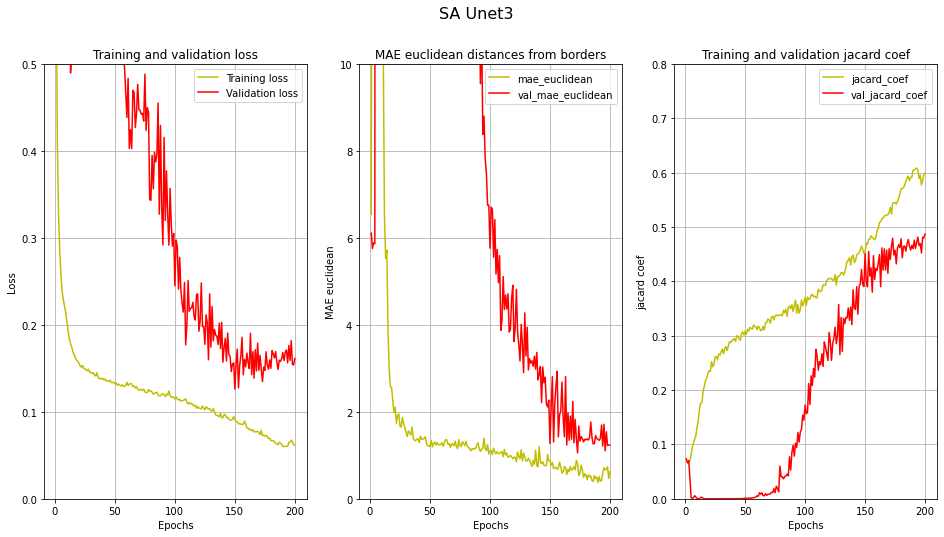

In [34]:
plot_history(history_sa_unet3, "SA Unet3")

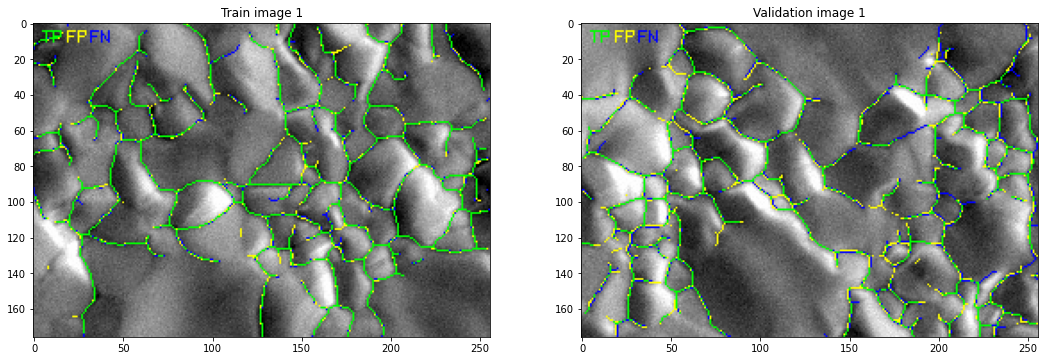

In [35]:
plot_train_val(model_sa_unet3, 1, 1)

The binary cross entropy produced similar MAE euclidean and a smaller jacard loss. Loss is approaching 0, limiting the space for improvement. The risk for overfitting with binary cross entropy is higher.

## SA Unet tuning - Adam parameters

In [36]:
# finding the optimal Adam seetings
def model_builder_SA_UNet_3(hp):   
    model = SA_UNet(input_shape, block_size=25, keep_prob=0.8, start_neurons=20)

    hp_learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.01, step=(0.01-0.001))  
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)  
    hp_beta_2 = hp.Float('beta_2', min_value=0.9, max_value=0.999, step=0.001)   
    
    model.compile(optimizer = Adam(learning_rate = hp_learning_rate, beta_1 = hp_beta_1, beta_2 = hp_beta_2),
                 loss = dice_coef_loss,
                 metrics=[mae_euclidean, jacard_coef])
        
    return model

In [37]:
tuner3 = kt.BayesianOptimization(model_builder_SA_UNet_3,
                                     objective = kt.Objective("val_mae_euclidean", direction='min'), 
                                     max_trials=10,
                                     seed = 14,
                                     directory=os.path.normpath('C:/keras_tuner'),
                                     project_name='2022-02-16_SA_UNet_tune3')

INFO:tensorflow:Reloading Oracle from existing project C:\keras_tuner\2022-02-16_SA_UNet_tune3\oracle.json
INFO:tensorflow:Reloading Tuner from C:\keras_tuner\2022-02-16_SA_UNet_tune3\tuner0.json


In [38]:
tf.random.set_seed(14)
tuner3.search(X_train, y_train,
             validation_data = (X_val, y_val),
             batch_size = 8,
             epochs=200
            ) 

INFO:tensorflow:Oracle triggered exit


In [39]:
tuner3.results_summary(num_trials=10)

Results summary
Results in C:\keras_tuner\2022-02-16_SA_UNet_tune3
Showing 10 best trials
Objective(name='val_mae_euclidean', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.85
beta_2: 0.919
Score: 0.8949853777885437
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.85
beta_2: 0.9
Score: 0.8990997076034546
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.85
beta_2: 0.9530000000000001
Score: 0.9050353765487671
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.85
beta_2: 0.914
Score: 0.9506241083145142
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.85
beta_2: 0.937
Score: 0.9784936308860779
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.87
beta_2: 0.9670000000000001
Score: 1.0058289766311646
Trial summary
Hyperparameters:
learning_rate: 0.010000000000000002
beta_1: 0.85
beta_2: 0.9990000000000001
Score:

The best parameters differ from the already used, but the benefits are small/negligible. All top settings use beta_1=0.85, which is on the edge of the search space; lower beta_1 might be beneficial, but not be explored in this work. Let's train and look at the curves.

In [41]:
# SA Unet4
# changing the Adam parameters learning_rate=1e-2, beta_1=0.85, beta_2=0.919
tf.random.set_seed(14)
model_sa_unet4 = SA_UNet(input_shape, block_size=25, keep_prob=0.8, start_neurons=20)
model_sa_unet4.compile(optimizer=Adam(learning_rate=1e-2, beta_1=0.85, beta_2=0.919),
                         loss = dice_coef_loss,
                         metrics=[mae_euclidean, jacard_coef]
                         )
start = time.time()
history_sa_unet4 = model_sa_unet4.fit(X_train, y_train,
                                    validation_data = (X_val, y_val),
                                    batch_size = 8, # no resources for 16
                                    epochs=200
                                   )
print(f"Model trained for {time.time() - start}s")
model_sa_unet4.save("2022-02-17 SA-UNet4 200epochs.hdf5")

Epoch 1/200
4/4 [==============================] - 5s 583ms/step - loss: 0.8377 - mae_euclidean: 5.3094 - jacard_coef: 0.0892 - val_loss: 0.8610 - val_mae_euclidean: 5.9715 - val_jacard_coef: 0.0747
Epoch 2/200
4/4 [==============================] - 2s 485ms/step - loss: 0.7669 - mae_euclidean: 3.6656 - jacard_coef: 0.1322 - val_loss: 0.9999 - val_mae_euclidean: 159.4866 - val_jacard_coef: 6.1341e-05
Epoch 3/200
4/4 [==============================] - 2s 485ms/step - loss: 0.7218 - mae_euclidean: 3.2920 - jacard_coef: 0.1616 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 4.4674e-05
Epoch 4/200
4/4 [==============================] - 2s 485ms/step - loss: 0.6825 - mae_euclidean: 3.0739 - jacard_coef: 0.1888 - val_loss: 1.0000 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 3.6861e-05
Epoch 5/200
4/4 [==============================] - 2s 487ms/step - loss: 0.6443 - mae_euclidean: 2.7700 - jacard_coef: 0.2171 - val_loss: 1.0000 - val_m

Epoch 38/200
4/4 [==============================] - 2s 494ms/step - loss: 0.3236 - mae_euclidean: 1.1611 - jacard_coef: 0.5112 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 9.2548e-05
Epoch 39/200
4/4 [==============================] - 2s 495ms/step - loss: 0.3142 - mae_euclidean: 1.0212 - jacard_coef: 0.5219 - val_loss: 0.9998 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 1.2138e-04
Epoch 40/200
4/4 [==============================] - 2s 494ms/step - loss: 0.3227 - mae_euclidean: 1.2094 - jacard_coef: 0.5122 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 7.8660e-05
Epoch 41/200
4/4 [==============================] - 2s 495ms/step - loss: 0.3244 - mae_euclidean: 1.0948 - jacard_coef: 0.5103 - val_loss: 0.9999 - val_mae_euclidean: 18446742974197923840.0000 - val_jacard_coef: 5.4871e-05
Epoch 42/200
4/4 [==============================] - 2s 496ms/step - loss: 0.3244 - mae_euclidean: 1.1824 - j

4/4 [==============================] - 2s 499ms/step - loss: 0.2835 - mae_euclidean: 0.9210 - jacard_coef: 0.5583 - val_loss: 0.9957 - val_mae_euclidean: 59.7613 - val_jacard_coef: 0.0022
Epoch 76/200
4/4 [==============================] - 2s 500ms/step - loss: 0.2863 - mae_euclidean: 0.9944 - jacard_coef: 0.5551 - val_loss: 0.9978 - val_mae_euclidean: 66.0968 - val_jacard_coef: 0.0011
Epoch 77/200
4/4 [==============================] - 2s 500ms/step - loss: 0.2925 - mae_euclidean: 1.1455 - jacard_coef: 0.5482 - val_loss: 0.9890 - val_mae_euclidean: 34.2576 - val_jacard_coef: 0.0055
Epoch 78/200
4/4 [==============================] - 2s 499ms/step - loss: 0.2917 - mae_euclidean: 1.0450 - jacard_coef: 0.5485 - val_loss: 0.9910 - val_mae_euclidean: 38.9680 - val_jacard_coef: 0.0046
Epoch 79/200
4/4 [==============================] - 2s 499ms/step - loss: 0.2833 - mae_euclidean: 0.9998 - jacard_coef: 0.5586 - val_loss: 0.9795 - val_mae_euclidean: 26.8988 - val_jacard_coef: 0.0104
Epoch 80

Epoch 116/200
4/4 [==============================] - 2s 496ms/step - loss: 0.2557 - mae_euclidean: 0.8813 - jacard_coef: 0.5930 - val_loss: 0.4765 - val_mae_euclidean: 3.2293 - val_jacard_coef: 0.3546
Epoch 117/200
4/4 [==============================] - 2s 497ms/step - loss: 0.2591 - mae_euclidean: 0.8282 - jacard_coef: 0.5884 - val_loss: 0.5298 - val_mae_euclidean: 3.6721 - val_jacard_coef: 0.3074
Epoch 118/200
4/4 [==============================] - 2s 496ms/step - loss: 0.2505 - mae_euclidean: 0.9443 - jacard_coef: 0.5995 - val_loss: 0.5121 - val_mae_euclidean: 3.6178 - val_jacard_coef: 0.3227
Epoch 119/200
4/4 [==============================] - 2s 494ms/step - loss: 0.2557 - mae_euclidean: 0.8527 - jacard_coef: 0.5928 - val_loss: 0.4868 - val_mae_euclidean: 3.3195 - val_jacard_coef: 0.3452
Epoch 120/200
4/4 [==============================] - 2s 496ms/step - loss: 0.2495 - mae_euclidean: 0.9600 - jacard_coef: 0.6007 - val_loss: 0.4676 - val_mae_euclidean: 3.1279 - val_jacard_coef: 0.

Epoch 157/200
4/4 [==============================] - 2s 499ms/step - loss: 0.2243 - mae_euclidean: 0.7166 - jacard_coef: 0.6337 - val_loss: 0.3242 - val_mae_euclidean: 1.2267 - val_jacard_coef: 0.5103
Epoch 158/200
4/4 [==============================] - 2s 498ms/step - loss: 0.2351 - mae_euclidean: 0.8453 - jacard_coef: 0.6194 - val_loss: 0.3274 - val_mae_euclidean: 1.2356 - val_jacard_coef: 0.5067
Epoch 159/200
4/4 [==============================] - 2s 500ms/step - loss: 0.2207 - mae_euclidean: 0.7114 - jacard_coef: 0.6385 - val_loss: 0.3646 - val_mae_euclidean: 2.0152 - val_jacard_coef: 0.4656
Epoch 160/200
4/4 [==============================] - 2s 499ms/step - loss: 0.2199 - mae_euclidean: 0.8186 - jacard_coef: 0.6396 - val_loss: 0.3124 - val_mae_euclidean: 1.2556 - val_jacard_coef: 0.5239
Epoch 161/200
4/4 [==============================] - 2s 498ms/step - loss: 0.2248 - mae_euclidean: 0.7767 - jacard_coef: 0.6329 - val_loss: 0.3606 - val_mae_euclidean: 1.4555 - val_jacard_coef: 0.

Epoch 198/200
4/4 [==============================] - 2s 499ms/step - loss: 0.2095 - mae_euclidean: 0.9016 - jacard_coef: 0.6538 - val_loss: 0.3921 - val_mae_euclidean: 3.0633 - val_jacard_coef: 0.4367
Epoch 199/200
4/4 [==============================] - 2s 498ms/step - loss: 0.1990 - mae_euclidean: 0.6883 - jacard_coef: 0.6681 - val_loss: 0.3399 - val_mae_euclidean: 1.8824 - val_jacard_coef: 0.4926
Epoch 200/200
4/4 [==============================] - 2s 498ms/step - loss: 0.1982 - mae_euclidean: 0.7672 - jacard_coef: 0.6692 - val_loss: 0.3216 - val_mae_euclidean: 1.0686 - val_jacard_coef: 0.5134
Model trained for 395.8336317539215s


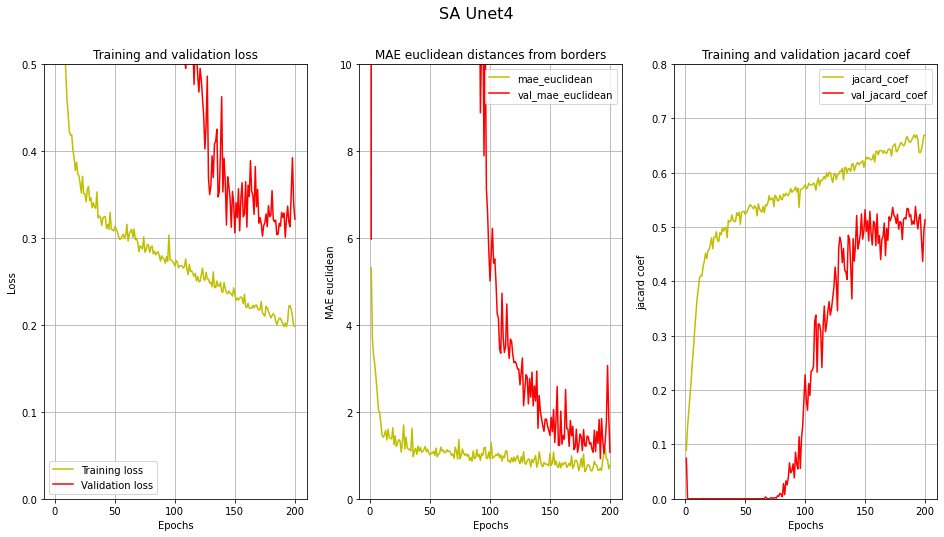

In [42]:
plot_history(history_sa_unet4, "SA Unet4")

Comparing the graphs from model_sa_unet4 and model_sa_unet2 gives indication for the effect of different beta_1 and beta_2. All the differences are within the noise of the curves. It would be preferred to use the default beta_1 and beta_2.

## Final model selection
The model model_sa_unet1 will be accepted as final.
Motivation:
- Best jacard coefficient; val_mae_euclidean among the best
- no overfitting
- light / fast model architecture with only 838279 parameters
- loss function experiments indicated dice loss as more suitable

Key implementation details:
- block_size=19, keep_prob=0.8, start_neurons=20
- Adam optimizer with learning rate 1e-2, beta_1=0.9, beta_2=0.999
- dice coefficient loss is used
- trained for 200 epochs
- batch size is 8

The trained model can be loaded from the file "2022-02-17 SA-UNet1 200epochs.hdf5". The custom metrics have to be specified during loading.

In [68]:
# best_model = model_sa_unet1
best_model = tf.keras.models.load_model('2022-02-17 SA-UNet1 200epochs.hdf5',
                                           custom_objects={'dice_coef_loss': dice_coef_loss,
                                                          'jacard_coef': jacard_coef,
                                                          'mae_euclidean': mae_euclidean,
                                                          'DropBlock2D' : DropBlock2D}
                                           )

## Final model analysis

In [69]:
best_model.summary()

Model: "SA_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 176, 256, 20  200         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 drop_block2d (DropBlock2D)     (None, 176, 256, 20  0           ['conv2d[0][0]']                 
                                )                                                           

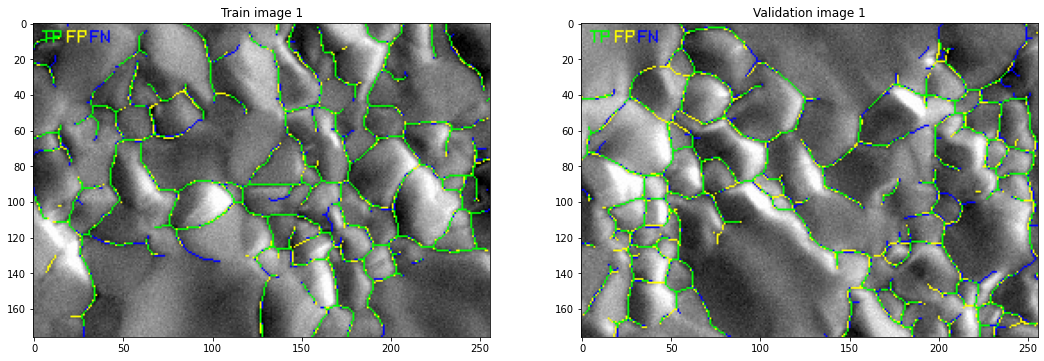

In [70]:
# photos with 500x scale
plot_train_val(best_model, 1, 1)

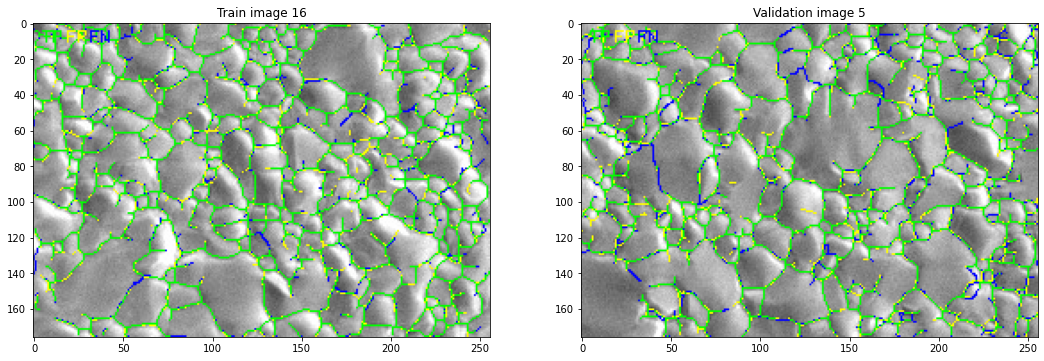

In [71]:
# photos with 1000x scale
plot_train_val(best_model, 16, 5)

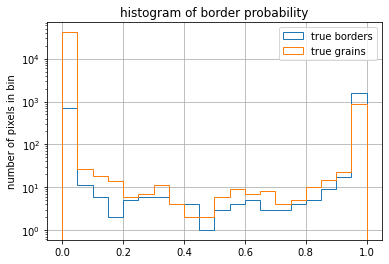

In [72]:
# plotting histogram of a valdiation picture
idx = 1
pred = best_model.predict(np.expand_dims(X_val[idx], 0)) 
pred = np.squeeze(pred)
gt_pixels = y_val[idx]
gt_pixels = np.squeeze(gt_pixels)
border = pred[gt_pixels == 1]
grain = pred[gt_pixels == 0]
plt.hist(border, bins=20, density=False, label='true borders', histtype='step')
plt.hist(grain, bins=20, density=False, label='true grains', histtype='step')
plt.title("histogram of border probability")
plt.ylabel("number of pixels in bin")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

The histograms shows good separation between border and grain pixels. The accepted threshold of 0.5 is good, reasonable changes of the threshold will not yield very different results. Looking at the histogram only, one could notice the classifficator performance is quite poor. However, when the spatial acceptance is added from the picture above, the results look quite promising. It appears that often FP and FN pixel borders are running in parallel - the shift could be due to errors in the ground truth. Some FP are actually quite questionable for the human and some people would classify them as borders.

In [73]:
# view the distance maps 
idx = 1
y_pred = best_model.predict(np.expand_dims(X_val[idx], 0))[0]
y_true = y_val[idx]

y_true_inv = (y_true == 0)
y_true_inv = tf.cast(y_true_inv, tf.uint8)
y_true_distance_map = tfa.image.euclidean_dist_transform(y_true_inv)  

y_pred_inv = (y_pred < 0.5)
y_pred_inv = tf.cast(y_pred_inv, tf.uint8)
y_pred_distance_map = tfa.image.euclidean_dist_transform(y_pred_inv)

error_euc_distances = tf.math.abs(tf.math.subtract(y_pred_distance_map, y_true_distance_map))
error_euc_distances = tf.squeeze(error_euc_distances).numpy()

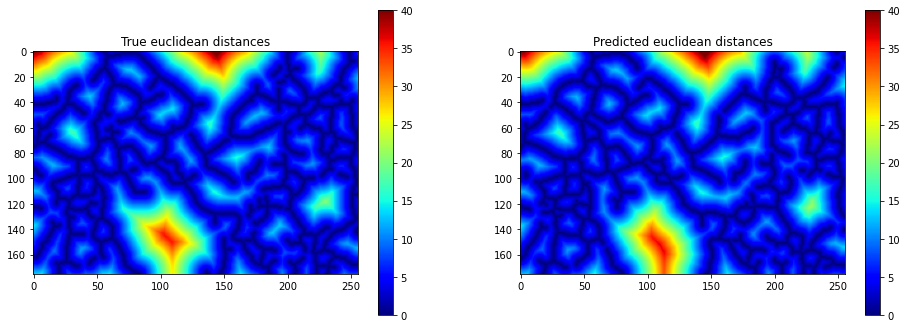

In [74]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
im = plt.imshow(y_true_distance_map, cmap='jet', vmax=40)
plt.colorbar(im, shrink=0.8)
plt.title("True euclidean distances")
plt.subplot(1, 2, 2)
im = plt.imshow(y_pred_distance_map, cmap='jet', vmax=40)
plt.colorbar(im, shrink=0.8)
plt.title("Predicted euclidean distances")
plt.show()

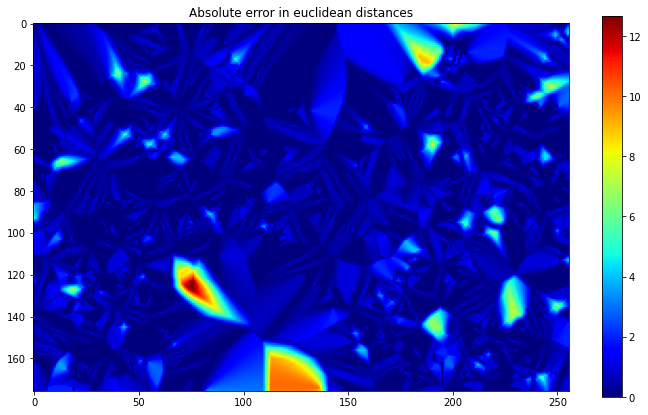

In [75]:
plt.figure(figsize=(12, 7))
im = plt.imshow(error_euc_distances, cmap='jet')
plt.colorbar(im)
plt.title("Absolute error in euclidean distances")
plt.show()

On the picture above, the zones with biggest error are in red.

## Final model evaluation

In [76]:
# model evaluation on train set
best_model.evaluate(X_train, y_train, batch_size=8)

4/4 [==============================] - 1s 58ms/step - loss: 0.2292 - mae_euclidean: 0.7226 - jacard_coef: 0.6282


[0.22923870384693146, 0.7226119041442871, 0.6281639337539673]

In [77]:
# model evaluation on validation set
best_model.evaluate(X_val, y_val, batch_size=8)

1/1 [==============================] - 0s 62ms/step - loss: 0.2979 - mae_euclidean: 1.2925 - jacard_coef: 0.5409


[0.2979312539100647, 1.292516827583313, 0.540920078754425]

In [78]:
# model evaluation on test set
best_model.evaluate(X_test, y_test, batch_size=8)

1/1 [==============================] - 0s 328ms/step - loss: 0.3015 - mae_euclidean: 1.1366 - jacard_coef: 0.5367


[0.3015058636665344, 1.1366015672683716, 0.5366954803466797]

The model performance is similar on the test and the validation dataset. 

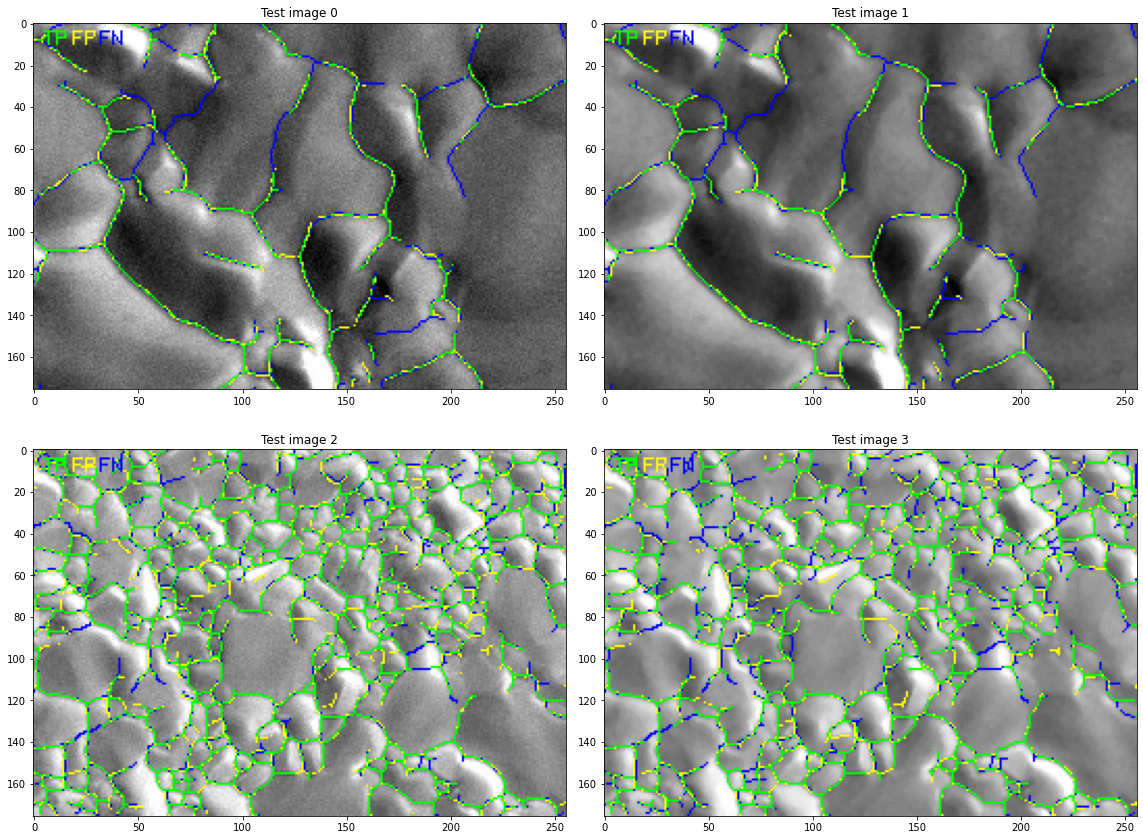

In [79]:
# analyzing all test images (original and augmented by median filter)
plt.figure(figsize=(16, 12))

for idx in range(X_test.shape[0]):
    im = visual_eval(model=best_model, test_img=X_test[idx], mask_expected=y_test[idx], show=False)
    plt.subplot(2, 2, idx+1)
    plt.imshow(im)
    plt.title(f"Test image {idx}")
plt.tight_layout()
plt.show()

Probably the FN pixels could be improved by adding more training data.

## Running the model on production images
(no manual labeling available)

### Functions needed for production

In [80]:
# functions needed to analyze full picture 1280x880 pixels
def create_patch_tensor(image):
    """
    prepares patches from image.
    the output tensor is with shape [25, 176, 256, 1] - 25 patches with resolution 176x256
    """
    im = np.expand_dims([image], -1)
    p = tf.image.extract_patches(images=im,
                           sizes=[1, 176, 256, 1],
                           strides=[1, 176, 256, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID') # small size of the image is lost
    n, r, c = p.shape[0], p.shape[1], p.shape[2]
    if r != 5 or c !=5:
        print(f"The function is intended for input shape of 880-893x1280 but shape {image.shape} was given")
    p = tf.reshape(p, [n*r*c, 176, 256, 1])
    return p


def get_border_mask_and_preview(img, model=best_model, thresh=0.50):
    assert (img.shape == (880, 1280))
    img = img_as_float32(img)
    img_p = create_patch_tensor(img)
    total_preview = np.zeros(tf.repeat(img_p, 3, axis=-1).shape)
    total_mask = np.zeros(tf.squeeze(img_p).shape, dtype=np.uint8)

    for i in range(5*5):
        patch = img_p[i]
        patch = img_as_float32(patch)
        preview = patch.copy()
        preview = tf.repeat(preview, 3, -1).numpy()
      
        pred = model.predict(np.expand_dims(patch, 0)) 
        
        if thresh !=0.5:
            mask = np.zeros(patch.shape[0:2])
            mask[np.squeeze(pred) > thresh] = 1
            preview[mask == 1] = (0.5, 0.5, 0.0)
        
        mask = np.zeros(patch.shape[0:2])
        mask[np.squeeze(pred) > 0.50] = 1
        preview[mask == 1] = (1.0, 0.0, 0.0)
                
        total_mask[i] = mask
        total_preview[i] = preview
        
    total_mask = np.reshape(total_mask, (5, 5, IMG_HEIGHT, IMG_WIDTH))
    total_mask = np.hstack(np.hstack(total_mask))
    
    total_preview = np.reshape(total_preview, (5, 5, IMG_HEIGHT, IMG_WIDTH, 3))
    total_preview = np.hstack(np.hstack(total_preview))

    return total_mask, total_preview


def get_grain_prop_and_preview(img, mask_boundaries):
    """
    img - input image, grayscale
    mask_boundaries - mask for the boundaries
    returns:
        - grain statistics
        - colored preview of the grains
    uses waterhed algorithm
    """
    if img.ndim != 2:
        raise ValueError("Grayscale image expected")
    if img.dtype != np.float64 and img.dtype != np.float32:
        raise ValueError("Image must be float32 or float64!")

    if img.dtype == np.float64:
        img = img_as_float32(img)

    # obtainning distance map and peaks
    mask_boundaries = mask_boundaries.astype(bool)
    mask_grains = ~mask_boundaries
    distance_map = ndimage.distance_transform_edt(mask_grains)
#     plt.imshow(mask_grains, cmap='jet')
#     return 0, 0
    peak_idx = peak_local_max(distance_map, min_distance=5, exclude_border=True)

    # filter unique peaks only, that are not connected to other peaks
    dmap = distance_map.copy() # dmap will be modified by flood fill
    unique_idx = []
    for peak in peak_idx: # start from biggest peaks to the smallest
        max_dist = dmap[peak[0], peak[1]] # the value of the peak at x, y
        if max_dist > 0:
            # this peak has not been eaten so far
            unique_idx.append(peak)
            dmap = flood_fill(dmap, (peak[0], peak[1]), new_value=0, tolerance=0.6*max_dist) #tolerance=0.3*max_dist
    unique_idx = np.array(unique_idx)

    # mask for major peaks that survived the flood_fill
    peak_mask = np.zeros_like(distance_map, dtype=bool)
    peak_mask[tuple(unique_idx.T)] = True
    cross = np.array([[0, 1, 0],
                     [1, 1, 1],
                     [0, 1, 0],])
    peak_preview = binary_dilation(peak_mask, cross)
    
    # mask for all peaks
    peak_mask_all = np.zeros_like(distance_map, dtype=bool)
    peak_mask_all[tuple(peak_idx.T)] = True
    peak_preview_all = binary_dilation(peak_mask_all, cross)

    # Perform connected component analysis then apply Watershed
    markers = ndimage.label(peak_mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-distance_map, markers, mask=mask_grains, watershed_line=True)
    labels = clear_border(labels)
    peak_preview[labels == 0] = 0 # remove the center annotation
    
    # create statistics
    regions = measure.regionprops(labels)  
    grain_prop = {'area': list(),
                 'd_max' : list()}
    for prop in regions:
        area = prop.filled_area
        perimeter = prop.perimeter
        grain_prop['area'].append(area + 0.5 * perimeter) 
        grain_prop['d_max'].append(prop.feret_diameter_max)
        
    # create colored picture
    x = np.linspace(0.0, 1, 20)
    colors = plt.get_cmap('tab20')(x)[:,:3] 
    colors = np.delete(colors, [14, 15], 0) # remove grays

    grain_preview = color.label2rgb(labels, image=img, colors=colors, bg_label=0, alpha=0.2)
    # grain_preview[peak_preview_all] = (0.5, 0.5, 0.5) # show minor centers of grains
    grain_preview[peak_preview] = (1, 1, 1) # show centers of grains
    grain_preview[~mask_grains] = (0.3, 0, 0) # show borders from the ML

    return grain_prop, grain_preview


def detec_grains_in_folder(path, model=best_model):
    """
    path should be without path separators
    makes preview and statistics for a folder
    """
    path_out = path

    df_folder = pd.DataFrame()
    for image in os.listdir(path):
        if image.split(".")[-1] == 'jpg':
            img_path = path + "\\" + image
            print(f"Working on {img_path}")
    
            # reading and processing the image
            img = io.imread(img_path, as_gray=True)
            img = img_as_float32(img)
 
            mask, mask_preview = get_border_mask_and_preview(img, model)
            grain_prop, colored_preview = get_grain_prop_and_preview(img, mask)

            # saving the ML borders
            vis = mask_preview.copy()
            vis[vis >1] = 1
            vis = img_as_ubyte(vis)
            new_filename = img_path.replace(".jpg", "_borders.tif")
            io.imsave(new_filename, vis)

            # saving colored grains
            vis = colored_preview.copy()
            vis[vis >1] = 1
            vis = img_as_ubyte(vis)
            new_filename = img_path.replace(".jpg", "_grains.tif")
            io.imsave(new_filename, vis)
            
            df_image = pd.DataFrame(grain_prop)
            df_image.area = df_image.area * 1 # number of pixels
            df_image.d_max = df_image.d_max * 1 # pixels
            df_image["file"] = image
            
            df_folder = pd.concat([df_folder, df_image], axis=0, ignore_index=True)
            
    df_folder.to_csv(path_out + "\\" + "grain_summary.csv")
        
    return df_folder

### Production run

In [81]:
# creating summaries in each folder
# grain_stats = detec_grains_in_folder(r"datasets\production") # already done

The processed images are stored in the original folder.

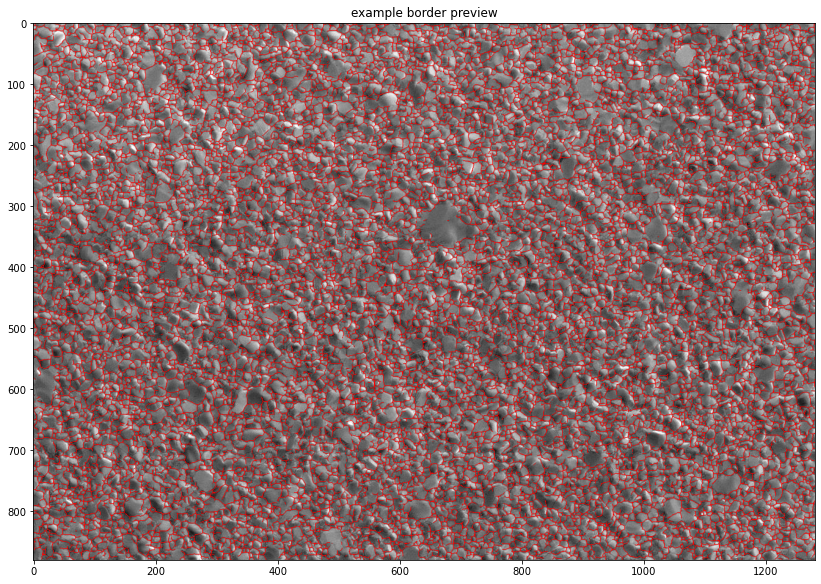

In [82]:
img = io.imread(r"datasets\production\production_1_borders.tif")
plt.figure(figsize=(14,10))
plt.imshow(img)
plt.title('example border preview')
plt.show()

# Backup

In [83]:
# removing image footer and renaming
# path = r"datasets\production"
# i = 1
# for image in os.listdir(path):
#     if image.split(".")[-1] == 'jpg':
#         img_path = path + "\\" + image
#         img = io.imread(img_path, as_gray=True)
#         img = img_as_ubyte(img)
#         img =  img[2:882,:]
#         io.imsave(path + f"\\production_{i}.jpg", img)
#         i += 1

# Discussion

Comparison to the ML approach using XGBoost https://github.com/Chehlarov/Machine-Learning/tree/main/00%20-%20project
- The ML approach required border pixel marking of 3 pixels to achieve good results. With Unets, the bordering labeling is single pixel and good results are obtained. 
- The Unet implementation does not require any preprocessing. The ML approach required denoising and histogram matching.
- The Unet does not require postprocessing like skeletonization or morphological operations.
- The Unet was trained simultaneously on patches with two different scales (x500 and x1000). The model performs well on both scale levels. 

Notes on the dataset:
- Shadows on the image have dominant direction and create false bias. One could apply augmentation by rotation/mirroring. Neither rotations nor mirroring are applied here, because photos are taken on the same SEM machine and the shadow direction is always the same.

Lessons learned:
- The much smaller SA-Unet performed better than larger Unets. The smaller network, and dropblock prevent overfitting effectively.
- Be careful with augmentations in the color space domain. Some augmentation might produce pictures impossible to be separated by human. If applying such approach, create the augmented pictures and manually inspect the feasibility of their use.

Ideas for improvement:
- Add loss function that does not put big penalty on false positives close to GT positive predictions. The manual pixel by pixel labeling cannot be 100% correct, such loss function might work better.
- Add weighted loss, obtained from distance map, based on GT. See "Distance Map Loss Penalty Term for Semantic Segmentation". 
- Augmentation by applying elastic deformations could be quite effective - https://www.kaggle.com/ori226/data-augmentation-with-elastic-deformations
- Train on images with more scale levels, if such are going to be used. Augmentation could also be used for down scaling.
- If more training data is to be added, it is best to apply the model on images and look for image types where the model under-performs. Manually correct a couple of patches, no need to correct the full picture. It is better to spend the labeling resources by covering several images by 1 or 2 patches. The added value of labeling all patches in an image is minimal, because the local features repeat a lot in one image.

Conclusions:
- Impressive results were achieved by training on patches of two labeled images.
- Small (trainable parameters: 838279) and effective model is proposed, ready to be applied on production scale.

# References

- Spatial Attention U-Net: https://arxiv.org/abs/2004.03696, https://github.com/clguo/SA-UNet
- U-net: https://arxiv.org/abs/1505.04597
- Attention U-net: https://arxiv.org/pdf/1804.03999.pdf
- Attention Residual U-Net: https://arxiv.org/abs/2004.03702
- code used from: https://youtu.be/L5iV5BHkMzM
- DropBlock: A regularization method for convolutional networks: https://arxiv.org/pdf/1810.12890.pdf
- A survey of loss functions for semantic segmentation https://arxiv.org/pdf/2006.14822.pdf
- Distance Map Loss Penalty Term for Semantic Segmentation https://arxiv.org/pdf/1908.03679.pdf